In [274]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
from geopandas import GeoSeries
import seaborn as sns
from itertools import chain
import json
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
%matplotlib inline
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape 
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from fiona.crs import from_epsg
import pysal as ps
from pysal.contrib.viz import mapping as maps
from tqdm import tqdm
from geopandas.tools import sjoin
import utm
from pyproj import Proj

In [275]:
plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In [276]:
def check(point, polygon):
    if any(polygon.contains(point)):
        return True
    else:
        return False

def checkPoly(point,polygonArray):
    truths = [check(point , poly) for poly in polygonArray]
    return any(truths)

In [277]:
# ogr2ogr -t_srs EPSG:4326 LB_WGS84.shp London_Borough_Excluding_MHW.shp
shp = fiona.open('../Data/Geo_Data/geo/london_wards.shp') # London_Borough_Excluding_MHW_wgs84.shp
crs_data = shp.crs
print(crs_data)
bds = shp.bounds
print (bds)
shp.close()
extra = 0.01
# bounds need to be datum-shifted
#wgs84 = pyproj.Proj("+init=EPSG:4326")
#osgb36 = pyproj.Proj("+init=EPSG:27700")
#ll = pyproj.transform(osgb36, wgs84, bds[0], bds[1])
#ur = pyproj.transform(osgb36, wgs84, bds[2], bds[3])
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
print (coords)

w, h = coords[2] - coords[0], coords[3] - coords[1]

print (w,h)

{}
(-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894)
[-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894]
(0.8443906332745678, 0.4051139537590416)


In [278]:
shp.crs

{}

In [279]:
ward_frame = gpd.read_file('../Data/Geo_Data/geo/london_wards.shp')
wardCodeDict = {}
for index , row in ward_frame.iterrows():
    wardCodeDict[row['NAME']] = row['CODE']

In [280]:
wardCodeDict

{u'Abbey Road Ward': u'E05000630',
 u'Abbey Ward': u'E05000026',
 u'Abbey Wood Ward': u'E05000214',
 u'Abingdon Ward': u'E05000382',
 u'Acton Central Ward': u'E05000170',
 u'Addiscombe Ward': u'E05000146',
 u'Addison Ward': u'E05000250',
 u'Aldborough Ward': u'E05000495',
 u'Aldersgate Ward': u'E05009288',
 u'Aldgate Ward': u'E05009289',
 u'Alexandra Ward': u'E05000266',
 u'Alibon Ward': u'E05000027',
 u'Alperton Ward': u'E05000085',
 u'Ashburton Ward': u'E05000147',
 u'Askew Ward': u'E05000251',
 u'Avonmore and Brook Green Ward': u'E05000252',
 u'Balham Ward': u'E05000610',
 u'Barkingside Ward': u'E05000496',
 u'Barnehurst Ward': u'E05000064',
 u'Barnes Ward': u'E05000516',
 u'Barnhill Ward': u'E05000086',
 u'Barnsbury Ward': u'E05000366',
 u'Bassishaw Ward': u'E05009290',
 u'Bayswater Ward': u'E05000631',
 u'Beckton Ward': u'E05000475',
 u'Becontree Ward': u'E05000028',
 u'Beddington North Ward': u'E05000555',
 u'Beddington South Ward': u'E05000556',
 u'Bedfont Ward': u'E05000346',
 

(649,
 5,
 [-0.5103750689005356, 51.28676016315085, 0.0, 0.0],
 [0.3340155643740321, 51.691874116909894, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x7fc51d396dd0>)

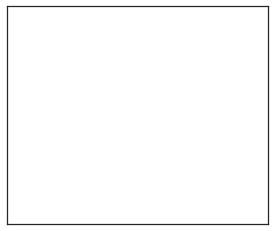

In [281]:
m = Basemap(
    projection='tmerc',
    lon_0 = -2.,
    lat_0 = 49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    '../Data/Geo_Data/geo/london_wards',
    'london',
    color='none',
    zorder=2)

In [282]:
m(58.6, -0)

(8381524.148270389, -5684368.573050952)

In [283]:
london_polys = []
borough_names = []
for w_ind in range(len(m.london_info)):
    w = m.london_info[w_ind]
    if w['CODE'] in borough_names:
        london_polys[-1] = Polygon(m.london[w_ind])
        continue
    borough_names.append(w['CODE'])    
    london_polys.append(Polygon(m.london[w_ind]))
    
df_map = pd.DataFrame({
    'poly': london_polys,
    'borough_name': borough_names,
})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['borough_name'] = df_map['borough_name'].str.strip()

In [284]:
data_file1 = '../Data/Geo_Data/GreaterLondon_NoRot_segnet.csv'
lonlat_data_file = '../Data/Geo_Data/greater_london_points.csv'
stephen_data = 'GLa_tree_loc.csv'

In [285]:
pd.read_csv(data_file1,sep='|').head()

,WayID,PointID,Rotation,SegnetRatios
0,8363123,1077704848,0,"[0.27945023148148146, 0.09033564814814815, 0.0..."
1,16790097,173736413,0,"[0.2711574074074074, 0.24954282407407408, 0.00..."
2,7995502,1564517311,0,"[0.36464699074074075, 0.06125, 0.0211747685185..."
3,8375945,195712,0,"[0.2757118055555556, 0.14144675925925926, 0.00..."
4,2955913,629000,0,"[0.08201967592592592, 0.5701157407407408, 0.00..."


In [286]:
Stephen_data = pd.read_csv(stephen_data)
Stephen_data .head()

,GLA_ID,Tree,treePercen,lon,lat
0,37439,1437,0.008316,-0.160338,51.590471
1,71396,27531,0.159323,0.093273,51.351336
2,76511,24614,0.142442,0.039291,51.461303
3,53705,9961,0.057645,-0.021153,51.432981
4,71914,27405,0.158594,0.101934,51.399035


In [287]:

trees_dict = {'id':[], 'geometry':[] , 'treePercent':[]}
for index,row in Stephen_data.iterrows():
    trees_dict['id'].append(row['GLA_ID'])
    trees_dict['geometry'].append(Point(row['lon'],row['lat']))
    trees_dict['treePercent'].append(row['treePercen'])

In [288]:
Stephen_trees = pd.DataFrame.from_dict(trees_dict)

In [289]:
stephen_trees_gdf = gpd.GeoDataFrame(Stephen_trees, geometry='geometry', crs={'init':'EPSG:4326'})

In [290]:
stephen_trees_gdf.head()

,geometry,id,treePercent
0,POINT (-0.16034 51.59047),37439.0,0.008316
1,POINT (0.09327 51.35134),71396.0,0.159323
2,POINT (0.03929 51.46130),76511.0,0.142442
3,POINT (-0.02115 51.43298),53705.0,0.057645
4,POINT (0.10193 51.39903),71914.0,0.158594


In [291]:
stephen_trees_WGS84 = stephen_trees_gdf.to_crs({'proj': 'tmerc','ellps' : 'WGS84'})

In [292]:
stephen_trees_gdf.head()

,geometry,id,treePercent
0,POINT (-0.16034 51.59047),37439.0,0.008316
1,POINT (0.09327 51.35134),71396.0,0.159323
2,POINT (0.03929 51.46130),76511.0,0.142442
3,POINT (-0.02115 51.43298),53705.0,0.057645
4,POINT (0.10193 51.39903),71914.0,0.158594


In [293]:
stephen_trees_WGS84.head()

,geometry,id,treePercent
0,POINT (-11111.867 5717790.119),37439.0,0.008316
1,POINT (6497.965 5691176.612),71396.0,0.159323
2,POINT (2730.687 5703407.654),76511.0,0.142442
3,POINT (-1471.037 5700256.170),53705.0,0.057645
4,POINT (7093.967 5696484.080),71914.0,0.158594


In [294]:
fdata_map_points = {}


for index, row in Stephen_data.iterrows():
    scene_list = [row['treePercen']]
    latitude  = row['lat']
    longitude = row['lon']
    fdata_map_points[m(longitude, latitude)] = scene_list

In [295]:
fdata_map_points

{(14550.206664323123, 22928.70256263789): [0.048263889000000004],
 (12575.947543361239, 34417.21799482996): [0.016070602],
 (21330.389472263705, 25531.721863429906): [0.17178819399999998],
 (49174.260647118615, 22767.650373192067): [0.089357639],
 (23134.4155303875, 24883.779201893514): [0.0069270830000000005],
 (49319.296142586594, 29658.376319236035): [0.01474537],
 (45829.45028385025, 31240.510094826313): [0.012835648],
 (25513.98822011912, 14904.023629745498): [0.022083332999999997],
 (21822.55826860106, 17545.08673083168): [0.077858796],
 (35723.485266680946, 34724.791361263575): [0.070491898],
 (25855.117743491195, 8220.458596051292): [0.119560185],
 (47259.02142464576, 21556.16584223995): [0.041921296000000004],
 (36535.81059264645, 19620.41631903677): [0.05320601900000001],
 (35710.98114939974, 29598.38081312008): [0.015821758999999998],
 (46623.25554399667, 33536.89295097577): [0.000387731],
 (27579.28132272871, 15567.319325568707): [0.045283565],
 (22226.726172450843, 19181.2

In [296]:
print Point(fdata_map_points.keys()[1])

POINT (12575.94754336124 34417.21799482996)


In [297]:
map_points = pd.Series(
    [Point(map_point) for map_point in fdata_map_points])
plaque_points = MultiPoint(list(map_points.values))
print len(plaque_points)
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = list(filter(wards_polygon.contains, plaque_points))

104777


In [298]:
ldn_points

 ...]

In [299]:
map_points = pd.Series(
    [Point(mapped_x, mapped_y) for (mapped_x, mapped_y) in fdata_map_points])
gsview_points = MultiPoint(list(map_points.values))
# calculate points that fall within the London boundary
gsview_ldn_points = list(filter(wards_polygon.contains, gsview_points))
# create a MultiPoint which we can check for set membership
df_map['gsview_point_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, gsview_ldn_points)))
df_map['gsview_segnet_tags_dict'] = df_map['gsview_point_list'].map(lambda x: [fdata_map_points[(p.x,p.y)] for p in x])

In [300]:
df_map

,borough_name,poly,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict
0,E05000405,"POLYGON ((13004.06946679378 5643.556704930117,...",7.557384e+06,75.573841,"[POINT (14081.01997090955 9315.405127737526), ...","[[0.10446759300000001], [0.17724537], [0.09480..."
1,E05000414,"POLYGON ((14432.57909461121 10890.80719812433,...",2.596590e+06,25.965904,"[POINT (16495.49459011841 10831.99421135875), ...","[[0.15640046300000002], [0.029658565], [0.0736..."
2,E05000401,"POLYGON ((14710.57509348575 12747.79659884245,...",1.454965e+06,14.549655,"[POINT (15929.72287402648 13309.97863293011), ...","[[0.137418981], [0.25369213], [0.064733796], [..."
3,E05000400,"POLYGON ((17083.95639115885 12354.05967180899,...",2.687010e+06,26.870103,"[POINT (16378.93891419472 11454.67815354353), ...","[[0.11577546300000001], [0.154733796], [0.1026..."
4,E05000402,"POLYGON ((18675.54168399898 13589.62372055175,...",1.879597e+06,18.795975,"[POINT (18158.11481960339 13634.54606621261), ...","[[0.001898148], [0.032430556], [0.023946758999..."
5,E05000406,"POLYGON ((18612.11378584463 14742.45080214852,...",4.424962e+06,44.249620,"[POINT (17674.93030232124 16839.84976342254), ...","[[0.08458333300000001], [0.069392361], [0.0397..."
6,E05000404,"POLYGON ((13778.04166202739 9520.496764869342,...",1.931236e+06,19.312361,"[POINT (14172.09056801898 9546.950876215502), ...","[[0.04957175900000001], [0.069010417], [0.0480..."
7,E05000413,"POLYGON ((14072.14004289791 12322.73661365363,...",1.666071e+06,16.660709,"[POINT (15016.42075516951 11430.69279392573), ...","[[0.062181713], [0.073142361], [0.118159722], ..."
8,E05000410,"POLYGON ((18835.70916394518 11458.93453373256,...",1.801488e+06,18.014876,"[POINT (17298.28853785373 12490.66350139838), ...","[[0.009519676], [0.001070602], [0.117407406999..."
9,E05000412,"POLYGON ((14063.43330370706 13247.47936071208,...",1.376784e+06,13.767837,"[POINT (14494.18616297658 12817.25534408094), ...","[[0.09057870400000001], [0.137997685], [0.0704..."


In [301]:
np.mean(np.array(df_map['gsview_segnet_tags_dict'].iloc[0]), axis=0)
scene_tags = []
total_pixels = []
for index in range(len(df_map)):
    scene_tags.append(np.mean(np.array(df_map['gsview_segnet_tags_dict'].iloc[index]), axis=0))
    total_pixels.append(np.sum(np.array(df_map['gsview_segnet_tags_dict'].iloc[index]), axis=0))
df_map['gsview_tags'] = scene_tags
df_map['total_gsview_pixels'] = total_pixels

# cats = ['Sky', 'Building', 'Pole','Road_Marking','Road','Pavement','Tree','Sign_Symbol','Fence','Vehicle','Pedestrian', 'Bike']
cats = ['Tree']

scene_tags_transpose = list(zip(*scene_tags))
scene_total_transpose = list(zip(*total_pixels))

for index in range(len(cats)):
    cat = cats[index]
    cat_total =  cats[index] + 'Total'
    df_map[cat] = scene_tags_transpose[index]
    df_map[cat_total] = scene_total_transpose[index]
    

In [302]:
np.array(df_map['gsview_segnet_tags_dict'].iloc[index])

array([[0.10446759],
       [0.17724537],
       [0.09480324],
       [0.16734954],
       [0.01213542],
       [0.03433449],
       [0.16613426],
       [0.08325231],
       [0.07435764],
       [0.11354745],
       [0.12198495],
       [0.07501157],
       [0.0827662 ],
       [0.07766782],
       [0.03239583],
       [0.08165509],
       [0.01649884],
       [0.12306134],
       [0.14457176],
       [0.08430556],
       [0.09625579],
       [0.01968171],
       [0.05668981],
       [0.10546296],
       [0.14696181],
       [0.08473958],
       [0.10265625],
       [0.08384259],
       [0.12071759],
       [0.05492477],
       [0.09473958],
       [0.07659143],
       [0.03638889],
       [0.07645255],
       [0.09905093],
       [0.03719329],
       [0.06553819],
       [0.04225694],
       [0.06757523],
       [0.12058449],
       [0.00264468],
       [0.05212384],
       [0.08504051],
       [0.02729745],
       [0.05177662],
       [0.0379456 ],
       [0.12779514],
       [0.155

In [303]:
len(zip(*scene_tags)[0])

649

In [332]:
df_map['samples'] = df_map['gsview_point_list'].apply(lambda x: len(x))

In [333]:
df_map

,borough_name,poly,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Tree,TreeTotal,TreeScore,samples,TreeScore_norm
0,E05000405,"POLYGON ((13004.06946679378 5643.556704930117,...",7.557384e+06,75.573841,"[POINT (14081.01997090955 9315.405127737526), ...","[[0.10446759300000001], [0.17724537], [0.09480...",[0.08016600295804195],[11.463738422999999],0.080166,11.463738,0.080166,143,0.080166
1,E05000414,"POLYGON ((14432.57909461121 10890.80719812433,...",2.596590e+06,25.965904,"[POINT (16495.49459011841 10831.99421135875), ...","[[0.15640046300000002], [0.029658565], [0.0736...",[0.05634974305130891],[10.762800922800002],0.056350,10.762801,0.056350,191,0.056350
2,E05000401,"POLYGON ((14710.57509348575 12747.79659884245,...",1.454965e+06,14.549655,"[POINT (15929.72287402648 13309.97863293011), ...","[[0.137418981], [0.25369213], [0.064733796], [...",[0.10434428858415842],[10.538773147],0.104344,10.538773,0.104344,101,0.104344
3,E05000400,"POLYGON ((17083.95639115885 12354.05967180899,...",2.687010e+06,26.870103,"[POINT (16378.93891419472 11454.67815354353), ...","[[0.11577546300000001], [0.154733796], [0.1026...",[0.0849857403986928],[13.002818281],0.084986,13.002818,0.084986,153,0.084986
4,E05000402,"POLYGON ((18675.54168399898 13589.62372055175,...",1.879597e+06,18.795975,"[POINT (18158.11481960339 13634.54606621261), ...","[[0.001898148], [0.032430556], [0.023946758999...",[0.06420874999199999],[8.026093749],0.064209,8.026094,0.064209,125,0.064209
5,E05000406,"POLYGON ((18612.11378584463 14742.45080214852,...",4.424962e+06,44.249620,"[POINT (17674.93030232124 16839.84976342254), ...","[[0.08458333300000001], [0.069392361], [0.0397...",[0.09323976458433735],[15.477800921],0.093240,15.477801,0.093240,166,0.093240
6,E05000404,"POLYGON ((13778.04166202739 9520.496764869342,...",1.931236e+06,19.312361,"[POINT (14172.09056801898 9546.950876215502), ...","[[0.04957175900000001], [0.069010417], [0.0480...",[0.08236987200694444],[11.861261569],0.082370,11.861262,0.082370,144,0.082370
7,E05000413,"POLYGON ((14072.14004289791 12322.73661365363,...",1.666071e+06,16.660709,"[POINT (15016.42075516951 11430.69279392573), ...","[[0.062181713], [0.073142361], [0.118159722], ...",[0.09764901622115384],[10.155497686999999],0.097649,10.155498,0.097649,104,0.097649
8,E05000410,"POLYGON ((18835.70916394518 11458.93453373256,...",1.801488e+06,18.014876,"[POINT (17298.28853785373 12490.66350139838), ...","[[0.009519676], [0.001070602], [0.117407406999...",[0.07851979568275863],[11.385370374],0.078520,11.385370,0.078520,145,0.078520
9,E05000412,"POLYGON ((14063.43330370706 13247.47936071208,...",1.376784e+06,13.767837,"[POINT (14494.18616297658 12817.25534408094), ...","[[0.09057870400000001], [0.137997685], [0.0704...",[0.08943211360769229],[11.626174768999999],0.089432,11.626175,0.089432,130,0.089432


In [334]:
df_map['TreeScore_norm'] = (df_map['TreeTotal']/df_map['samples'])

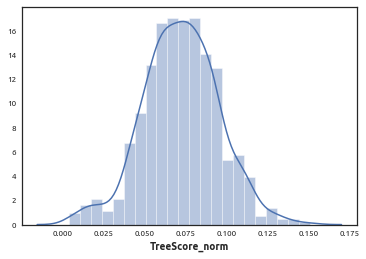

In [335]:
sns.distplot(df_map['TreeScore_norm'])

In [336]:
Tree_df = df_map[['borough_name','TreeScore_norm','samples']]

In [337]:
Tree_df.to_csv('Revised_tree_score.csv')

In [313]:
df_map.to_csv('London_ward_tree_scores_stephen.csv')

In [305]:
df_map.columns

Index([u'borough_name', u'poly', u'area_m', u'area_km', u'gsview_point_list',
       u'gsview_segnet_tags_dict', u'gsview_tags', u'total_gsview_pixels',
       u'Tree', u'TreeTotal'],
      dtype='object')

In [226]:
tree_data = pd.read_csv('../Data/Geo_Data/london_street_trees_gla_20180214.csv')

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [227]:
len(tree_data)

726934

In [228]:
treeLocations = []
for index , row in tree_data.iterrows():
    point = Point(m(row['longitude'], row['latitude']))
    treeLocations.append(point)

In [229]:
print treeLocations[1]

POINT (44911.20345936637 35044.0926956278)


In [230]:
tree_points = pd.Series(treeLocations)
tree_data_points = MultiPoint(list(tree_points.values))
# calculate points that fall within the London boundary
tree_ldn_points = list(filter(wards_polygon.contains, tree_data_points))
# create a MultiPoint which we can check for set membership
df_map['Tree_location_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, tree_ldn_points)))
df_map['TreeCount'] = df_map['Tree_location_list'].map(lambda x: len(x))

In [231]:
df_map.head()

,borough_name,poly,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Tree,TreeTotal,Tree_location_list,TreeCount
0,E05000405,"POLYGON ((13004.06946679378 5643.556704930117,...",7.557384e+06,75.573841,"[POINT (14081.01997090955 9315.405127737526), ...","[[0.10446759300000001], [0.17724537], [0.09480...",[0.08016600295804195],[11.463738422999999],0.080166,11.463738,"[POINT (14517.9631249908 9426.159779180685), P...",91
1,E05000414,"POLYGON ((14432.57909461121 10890.80719812433,...",2.596590e+06,25.965904,"[POINT (16495.49459011841 10831.99421135875), ...","[[0.15640046300000002], [0.029658565], [0.0736...",[0.05634974305130891],[10.762800922800002],0.056350,10.762801,"[POINT (16576.51872432181 10953.0350912103), P...",53
2,E05000401,"POLYGON ((14710.57509348575 12747.79659884245,...",1.454965e+06,14.549655,"[POINT (15929.72287402648 13309.97863293011), ...","[[0.137418981], [0.25369213], [0.064733796], [...",[0.10434428858415842],[10.538773147],0.104344,10.538773,[],0
3,E05000400,"POLYGON ((17083.95639115885 12354.05967180899,...",2.687010e+06,26.870103,"[POINT (16378.93891419472 11454.67815354353), ...","[[0.11577546300000001], [0.154733796], [0.1026...",[0.0849857403986928],[13.002818281],0.084986,13.002818,"[POINT (16524.99709356503 11497.43654827776), ...",74
4,E05000402,"POLYGON ((18675.54168399898 13589.62372055175,...",1.879597e+06,18.795975,"[POINT (18158.11481960339 13634.54606621261), ...","[[0.001898148], [0.032430556], [0.023946758999...",[0.06420874999199999],[8.026093749],0.064209,8.026094,[],0


In [232]:
df_map.columns

Index([u'borough_name', u'poly', u'area_m', u'area_km', u'gsview_point_list',
       u'gsview_segnet_tags_dict', u'gsview_tags', u'total_gsview_pixels',
       u'Tree', u'TreeTotal', u'Tree_location_list', u'TreeCount'],
      dtype='object')

In [233]:
gdf = gpd.GeoDataFrame(df_map[df_map['TreeCount']>=10], crs={}, geometry='poly')

In [234]:
len(gdf)

575

In [235]:
gdf.head()

,borough_name,poly,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Tree,TreeTotal,Tree_location_list,TreeCount
0,E05000405,"POLYGON ((13004.069 5643.557, 13009.772 5652.2...",7.557384e+06,75.573841,"[POINT (14081.01997090955 9315.405127737526), ...","[[0.10446759300000001], [0.17724537], [0.09480...",[0.08016600295804195],[11.463738422999999],0.080166,11.463738,"[POINT (14517.9631249908 9426.159779180685), P...",91
1,E05000414,"POLYGON ((14432.579 10890.807, 14440.082 10913...",2.596590e+06,25.965904,"[POINT (16495.49459011841 10831.99421135875), ...","[[0.15640046300000002], [0.029658565], [0.0736...",[0.05634974305130891],[10.762800922800002],0.056350,10.762801,"[POINT (16576.51872432181 10953.0350912103), P...",53
3,E05000400,"POLYGON ((17083.956 12354.060, 17094.660 12346...",2.687010e+06,26.870103,"[POINT (16378.93891419472 11454.67815354353), ...","[[0.11577546300000001], [0.154733796], [0.1026...",[0.0849857403986928],[13.002818281],0.084986,13.002818,"[POINT (16524.99709356503 11497.43654827776), ...",74
5,E05000406,"POLYGON ((18612.114 14742.451, 18536.285 14807...",4.424962e+06,44.249620,"[POINT (17674.93030232124 16839.84976342254), ...","[[0.08458333300000001], [0.069392361], [0.0397...",[0.09323976458433735],[15.477800921],0.093240,15.477801,"[POINT (18401.57420806239 15390.48764707943), ...",64
6,E05000404,"POLYGON ((13778.042 9520.497, 13768.138 9631.5...",1.931236e+06,19.312361,"[POINT (14172.09056801898 9546.950876215502), ...","[[0.04957175900000001], [0.069010417], [0.0480...",[0.08236987200694444],[11.861261569],0.082370,11.861262,"[POINT (14505.65813167962 9519.194190858543), ...",39


In [236]:
# gdf.to_csv('Tree_Segnet_stephen_data.csv')

In [37]:
# df_map = pd.read_csv('Tree_Segnet.csv')

In [237]:
gdf['total_gsview_pixels'].iloc[2]

array([13.00281828])

In [238]:
sum(gdf['TreeCount'])

725496

In [239]:
polygon = gdf.iloc[15]['poly']

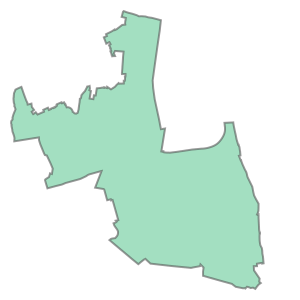

In [240]:
polygon

In [241]:
gdf.iloc[15].area_km

28.074912898052492

In [242]:
polygon.area

2807491.2898052493

In [243]:
# df_map.to_csv('Tree_Segnet.csv')

In [244]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x = gdf['TreeCount'].values.astype(float)
x2 = gdf['Tree'].values.astype(float)

minVal = float(np.min(x))
maxVal = float(np.max(x))

min_tree = float(np.min(x2))
max_tree = float(np.max(x2))

gdf['NormedTreeCount'] = (gdf['TreeCount']-minVal)/(maxVal-minVal)
gdf['NormedTreeSegnet'] = (gdf['Tree']-min_tree)/(max_tree-min_tree)

gdf['TreeDensity'] = np.log((gdf['TreeCount']*10.0)/gdf['area_km'])
gdf['TreePixelDensity'] = (gdf['TreeTotal']*10.0)/gdf['area_km']

In [245]:
gdf.columns

Index([u'borough_name', u'poly', u'area_m', u'area_km', u'gsview_point_list',
       u'gsview_segnet_tags_dict', u'gsview_tags', u'total_gsview_pixels',
       u'Tree', u'TreeTotal', u'Tree_location_list', u'TreeCount',
       u'NormedTreeCount', u'NormedTreeSegnet', u'TreeDensity',
       u'TreePixelDensity'],
      dtype='object')

In [246]:
gdf.head()

,borough_name,poly,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Tree,TreeTotal,Tree_location_list,TreeCount,NormedTreeCount,NormedTreeSegnet,TreeDensity,TreePixelDensity
0,E05000405,"POLYGON ((13004.069 5643.557, 13009.772 5652.2...",7.557384e+06,75.573841,"[POINT (14081.01997090955 9315.405127737526), ...","[[0.10446759300000001], [0.17724537], [0.09480...",[0.08016600295804195],[11.463738422999999],0.080166,11.463738,"[POINT (14517.9631249908 9426.159779180685), P...",91,0.004361,0.509314,2.488334,1.516892
1,E05000414,"POLYGON ((14432.579 10890.807, 14440.082 10913...",2.596590e+06,25.965904,"[POINT (16495.49459011841 10831.99421135875), ...","[[0.15640046300000002], [0.029658565], [0.0736...",[0.05634974305130891],[10.762800922800002],0.056350,10.762801,"[POINT (16576.51872432181 10953.0350912103), P...",53,0.002315,0.344078,3.016093,4.144974
3,E05000400,"POLYGON ((17083.956 12354.060, 17094.660 12346...",2.687010e+06,26.870103,"[POINT (16378.93891419472 11454.67815354353), ...","[[0.11577546300000001], [0.154733796], [0.1026...",[0.0849857403986928],[13.002818281],0.084986,13.002818,"[POINT (16524.99709356503 11497.43654827776), ...",74,0.003446,0.542753,3.315636,4.839140
5,E05000406,"POLYGON ((18612.114 14742.451, 18536.285 14807...",4.424962e+06,44.249620,"[POINT (17674.93030232124 16839.84976342254), ...","[[0.08458333300000001], [0.069392361], [0.0397...",[0.09323976458433735],[15.477800921],0.093240,15.477801,"[POINT (18401.57420806239 15390.48764707943), ...",64,0.002907,0.600020,2.671621,3.497838
6,E05000404,"POLYGON ((13778.042 9520.497, 13768.138 9631.5...",1.931236e+06,19.312361,"[POINT (14172.09056801898 9546.950876215502), ...","[[0.04957175900000001], [0.069010417], [0.0480...",[0.08236987200694444],[11.861261569],0.082370,11.861262,"[POINT (14505.65813167962 9519.194190858543), ...",39,0.001561,0.524605,3.005401,6.141798


In [247]:
gdf['GSV_samples_per_sqkm'] = 0
samplesPerWard = {}
for index, row in gdf.iterrows():
    samplesPerWard[row['borough_name']] = float(len(row['gsview_point_list'])*10.0)/row['area_km']
    gdf.at[index,'GSV_samples_per_sqkm'] = float(len(row['gsview_point_list'])*10.0)/row['area_km']
    

In [248]:
gdf['decile'] = pd.qcut(gdf['GSV_samples_per_sqkm'], q=10, precision=0)

In [249]:
gdf['decile_treeDensity'] = pd.qcut(gdf['TreeDensity'], q=10, precision=0)

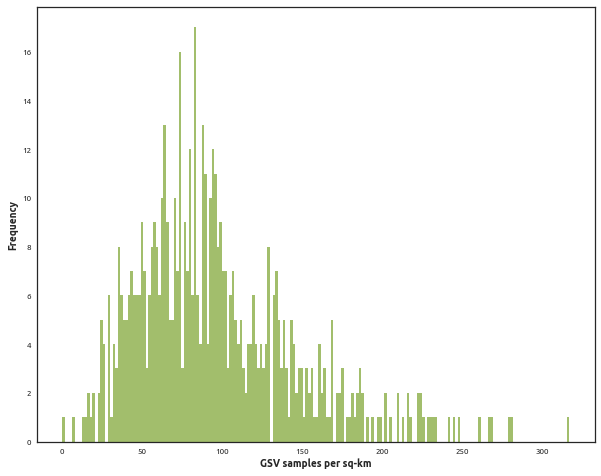

In [250]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('GSV samples per sq-km')
plt.ylabel('Frequency')
# plt.axvline(, color='r')
# plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(samplesPerWard.values(), 200, facecolor='g', alpha=0.75)

In [251]:
min(gdf['TreeCount'])

10

In [252]:
len(gdf)

575

In [253]:
# df_map.head()

In [254]:
from scipy.stats import pearsonr

In [255]:
corr = pearsonr(gdf['TreeCount'],gdf['Tree'])
print corr

(0.27194358011960357, 3.3076754826990604e-11)


/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.1,0.55,'Pearson r: 0.27***')

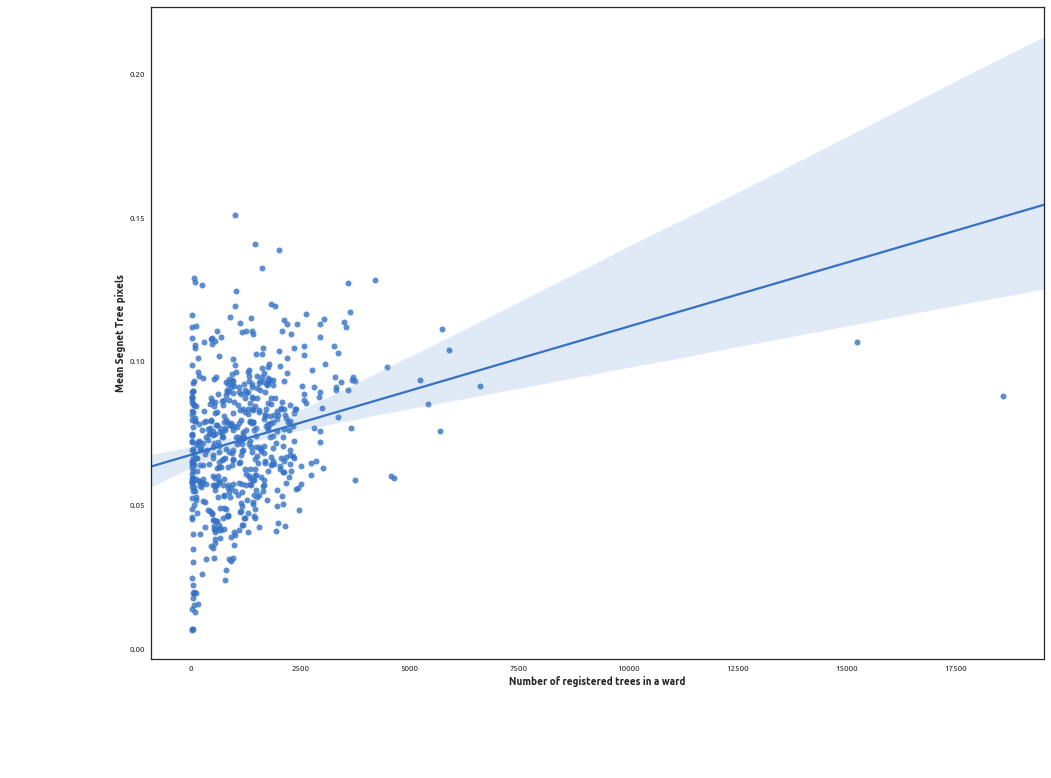

In [256]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="TreeCount", y="Tree", data=gdf);
plt.xlabel('Number of registered trees in a ward')
plt.ylabel('Mean Segnet Tree pixels')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(0.1, 0.55),fontsize = 20)

In [257]:
str(10)

'10'

In [258]:
greenScores = {}
for index , row in gdf.iterrows():
    greenScores[wardCodeDict[row['borough_name']]] = row['TreePixelDensity']

KeyError: 'E05000405'

In [ ]:
# import json
# json.dump(greenScores,open('London_ward_green_score.json','wb'))

(0.27369862016984325, 2.4440649569857356e-11)


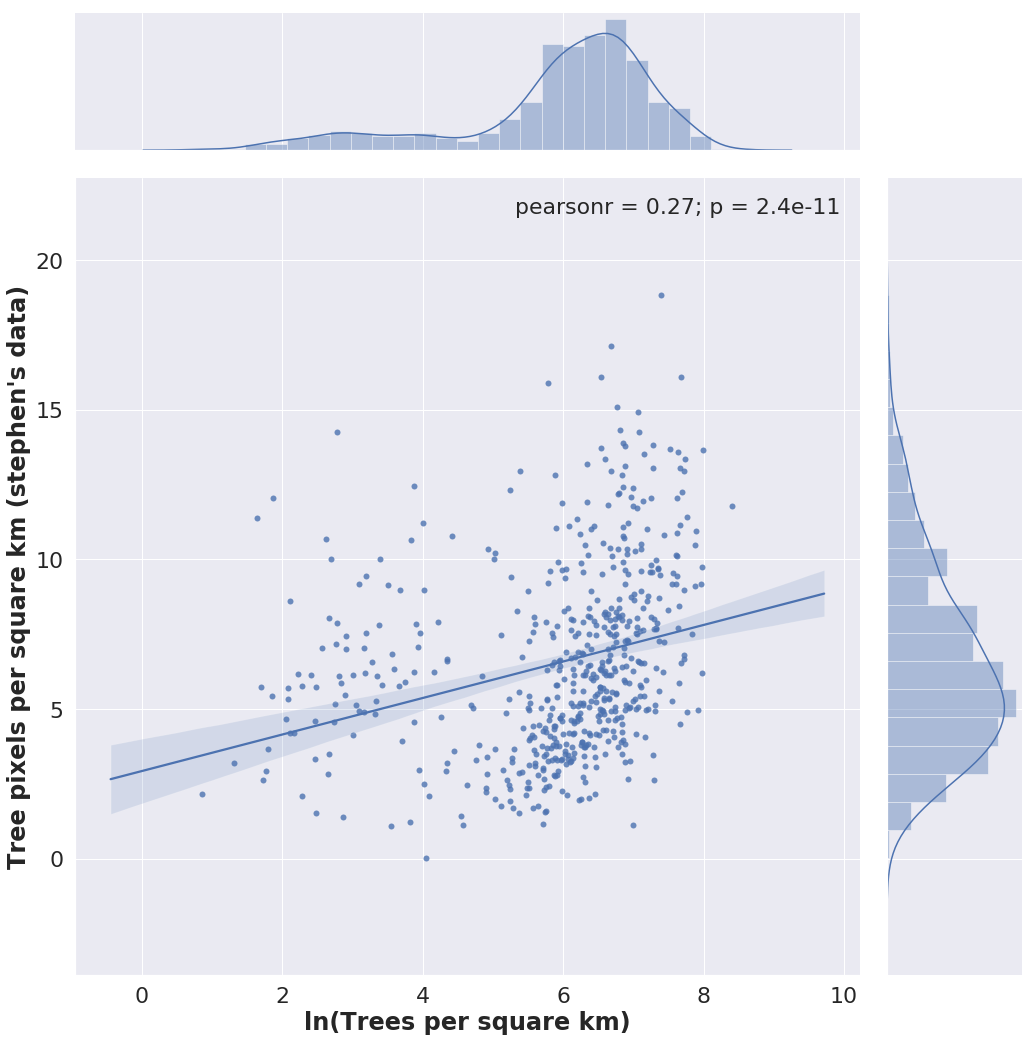

In [273]:
corr = pearsonr(gdf['TreeDensity'],gdf['TreePixelDensity'])
print corr
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
ax = sns.jointplot(x="TreeDensity", y="TreePixelDensity", data=gdf,kind='regression',height=15);
plt.xlabel('ln(Trees per square km)')
plt.ylabel('Tree pixels per square km (stephen\'s data)')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',fontsize = 20)
ax.annotate(pearsonr)

(0.6089201352065431, 1.238865632469652e-59)


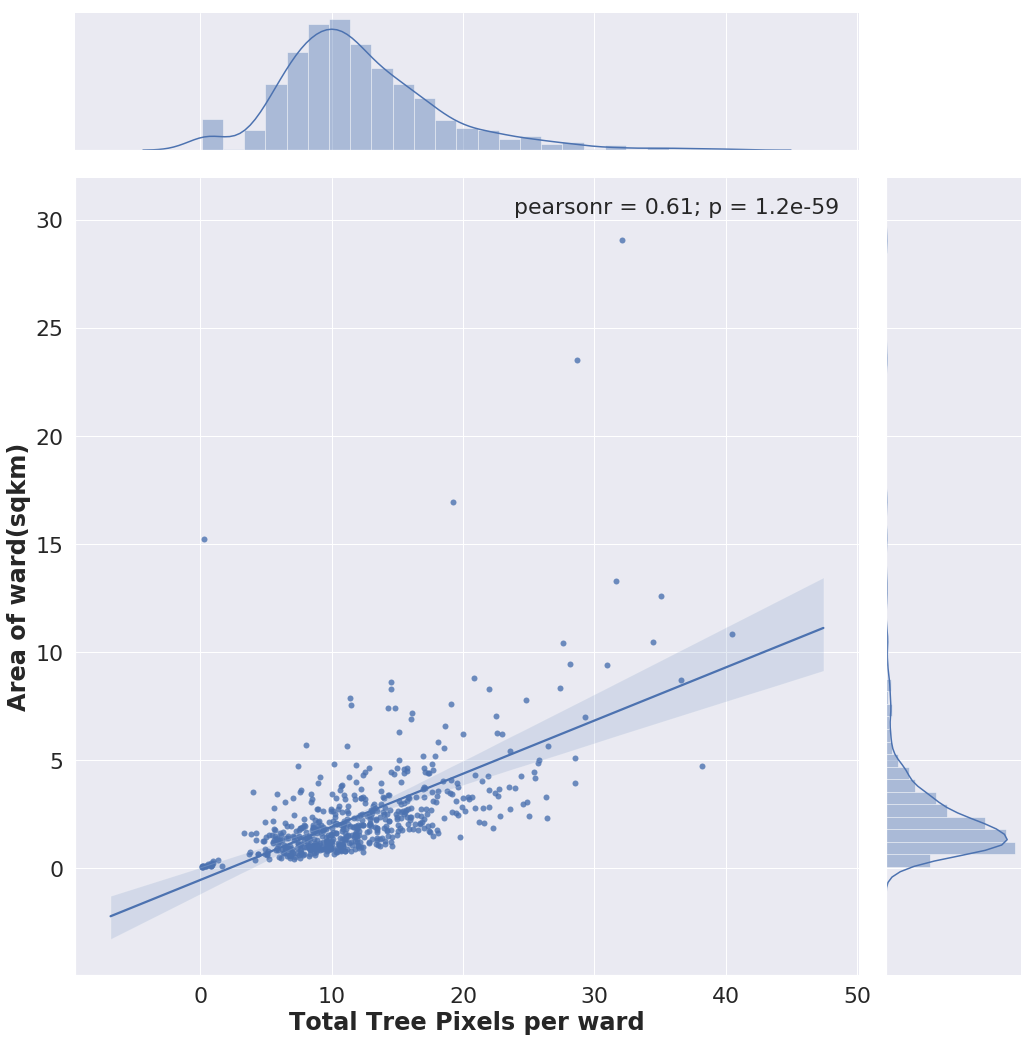

In [261]:
corr = pearsonr(gdf['TreeTotal'],gdf['area_km']/10)
print corr
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
ax = sns.jointplot(x=gdf['TreeTotal'], y=gdf['area_km']/10,kind='regression',height=15);
plt.xlabel('Total Tree Pixels per ward')
plt.ylabel('Area of ward(sqkm)')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',fontsize = 20)
ax.annotate(pearsonr)

In [262]:
corrs = []
bins = []
for name, group in gdf.groupby('decile'):
    bins.append(name)
    corr = pearsonr(group['TreeDensity'],group['TreePixelDensity'])
    corrs.append(corr)

In [263]:
corrs

[(0.27420784931266085, 0.03399368354733491),
 (0.13134827119232861, 0.3345747267717133),
 (0.15397495555825136, 0.24427894662568342),
 (0.08354196823503611, 0.5256818508187575),
 (-0.1331917290289823, 0.3188973259529965),
 (0.065770434656362, 0.6431849805168235),
 (-0.06520039959015934, 0.6236946047592693),
 (0.2987459857823026, 0.023987149496557177),
 (0.19607530272796603, 0.14380391115748115),
 (0.30587470925150817, 0.020673052842180045)]

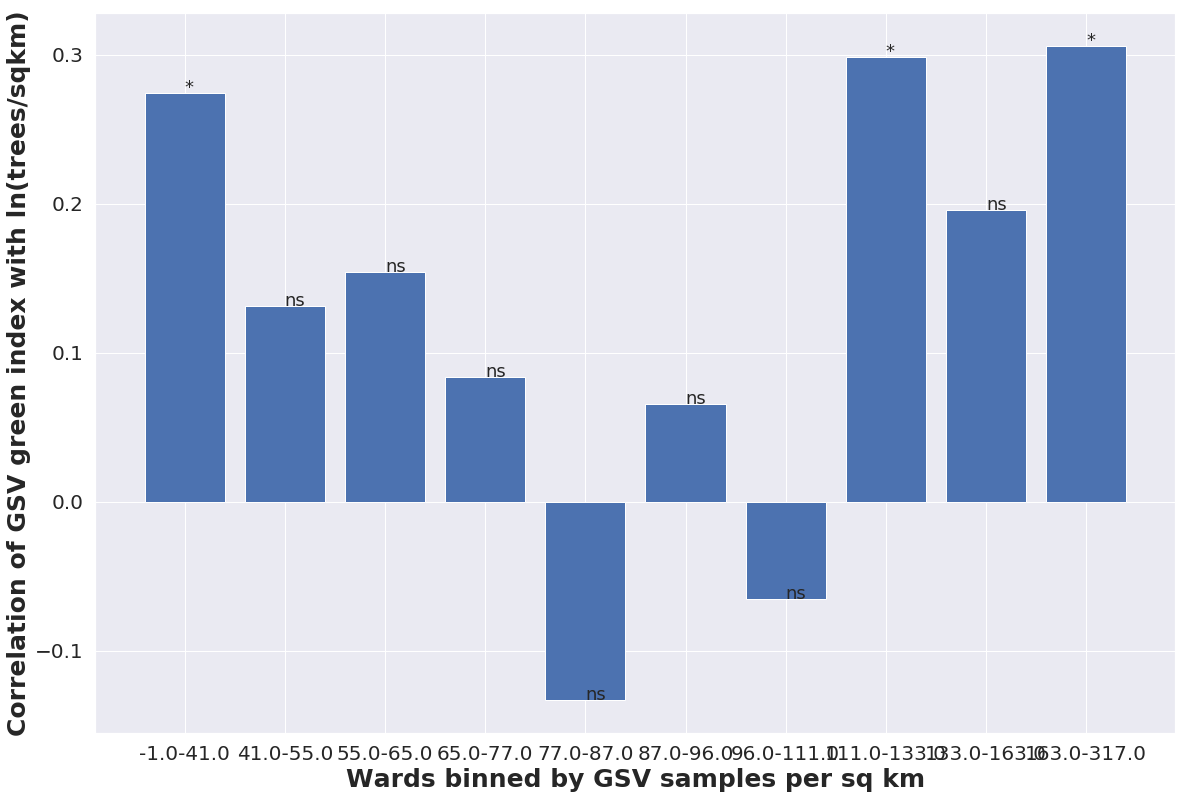

In [264]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Wards binned by GSV samples per sq km",fontsize = 25)
plt.ylabel("Correlation of GSV green index with ln(trees/sqkm)",fontsize = 25)
xlabels = [str(b.left)+'-'+str(b.right) for b in bins]
c = [corr[0] for corr in corrs]
ax.bar(xlabels,c)

p = []
for corr in corrs: 
    if corr[1] > 0.05:
        p.append('ns')
    elif corr[1] <= 0.05 and corr[1] > 0.01  :
        p.append('*')
    elif corr[1] <= 0.01 and corr[1] > 0.001:
        p.append('**')
    elif corr[1] <= 0.001 and corr[1] > 0.0001:
        p.append('**')
    elif corr[1] <= 0.0001 and corr[1] > 0.00001:
        p.append('***')
    else :
        p.append('****')
for xi, yi, l in zip(*[xlabels, c, p]):
    ax.text(xi, yi, l , fontsize = 18)
    
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [265]:
def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(r['borough_name'], xy=(r["TreeDensity"], r["TreePixelDensity"]), 
            xytext=(2,2) , textcoords ="offset points", fontsize = 10)

(0.2638616914522597, 0.04535046709136969)
(-0.1752736661112851, 0.19220223595703378)
(-0.2134337121734116, 0.10768735066075176)
(-0.026048943615417472, 0.8474752989800004)
(0.10561260372351049, 0.4300986536424306)
(0.05960913208357923, 0.6596034893375285)
(0.02658410786545023, 0.8443802966164158)
(0.009480027282804825, 0.9436941160705169)
(0.22458549497718247, 0.09304509048101202)
(0.22996444951013795, 0.08245955102834773)


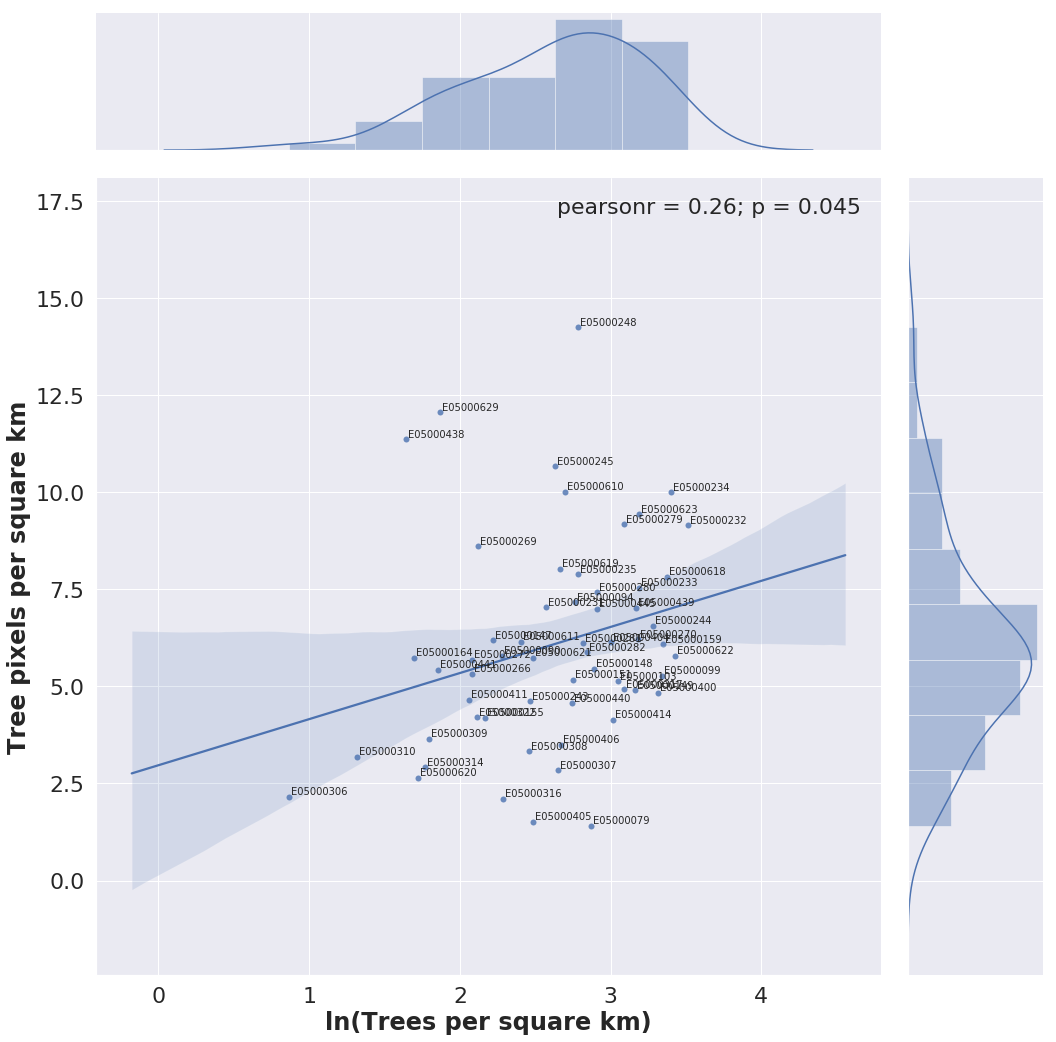

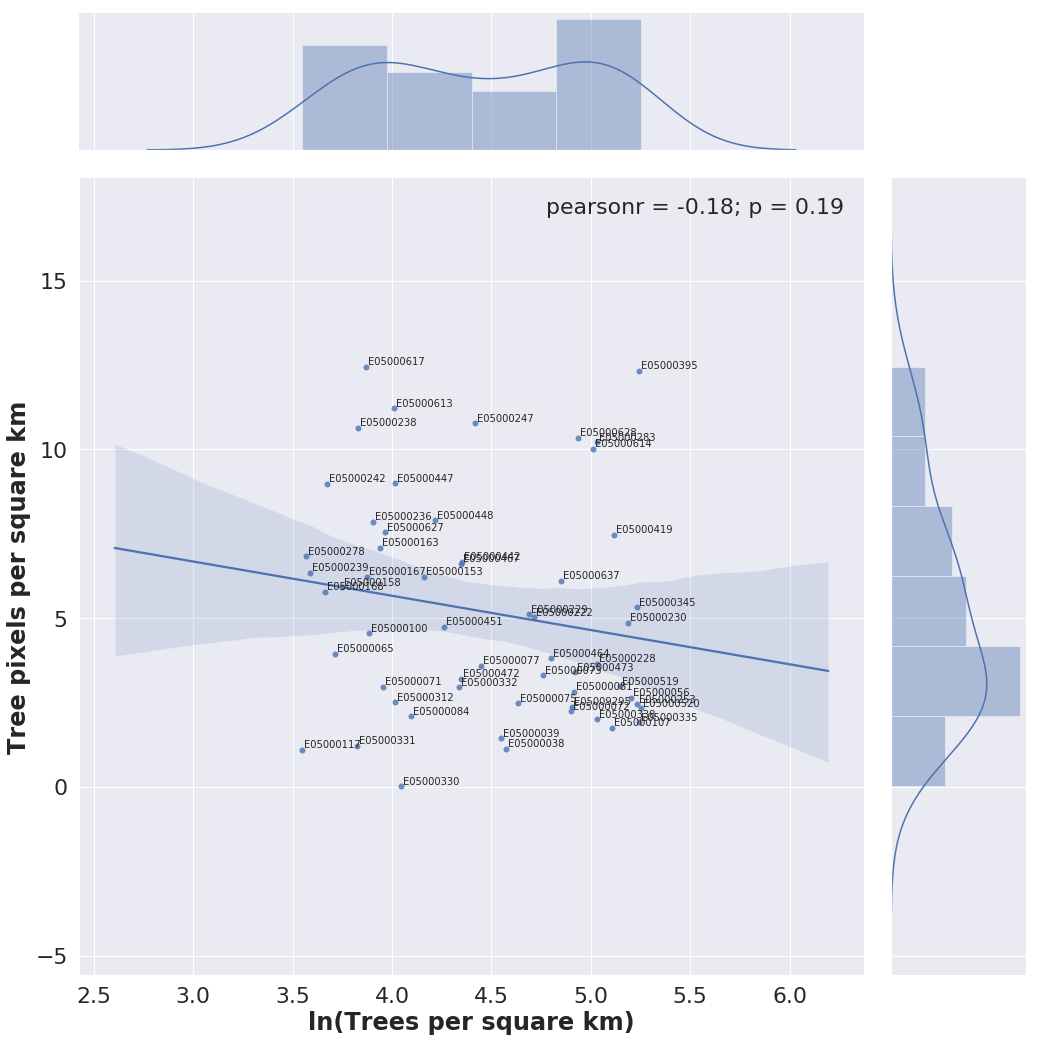

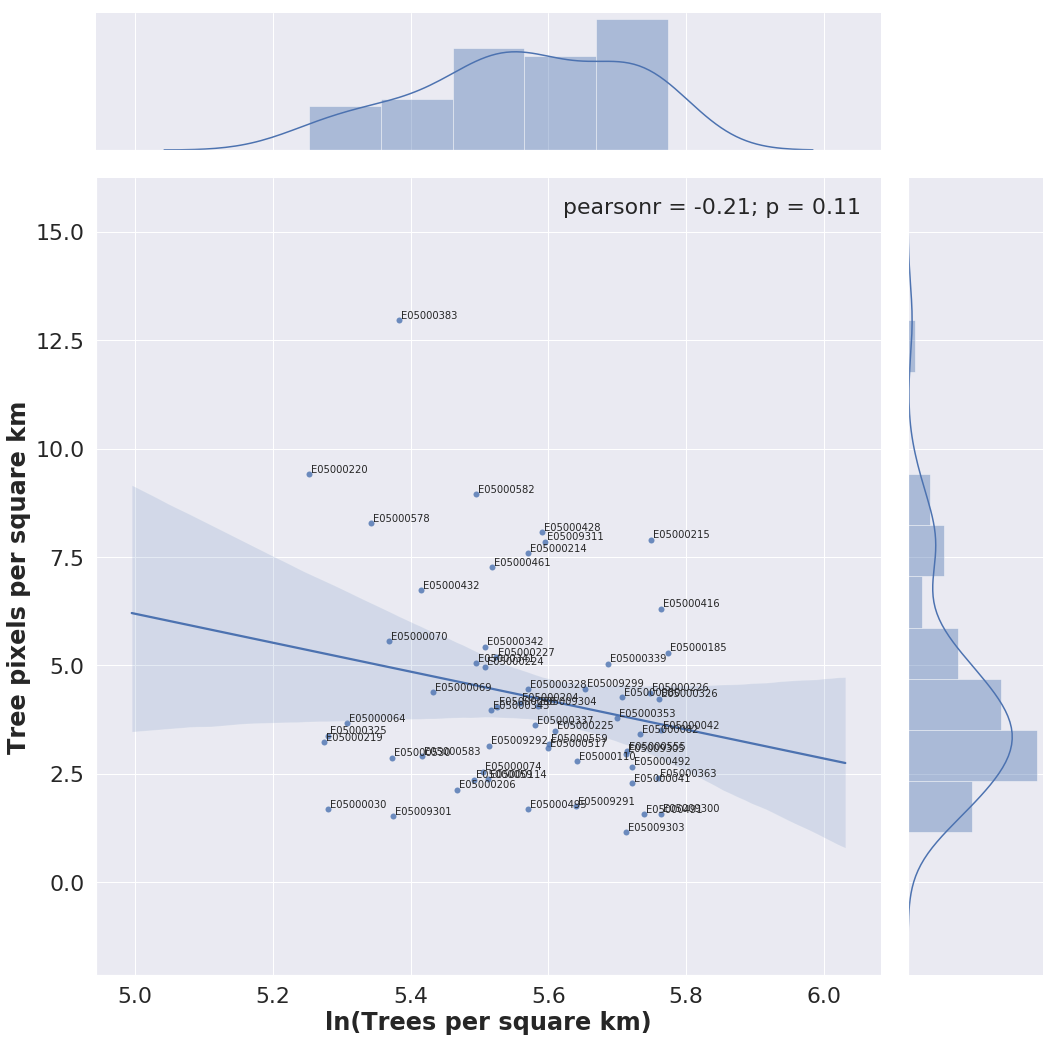

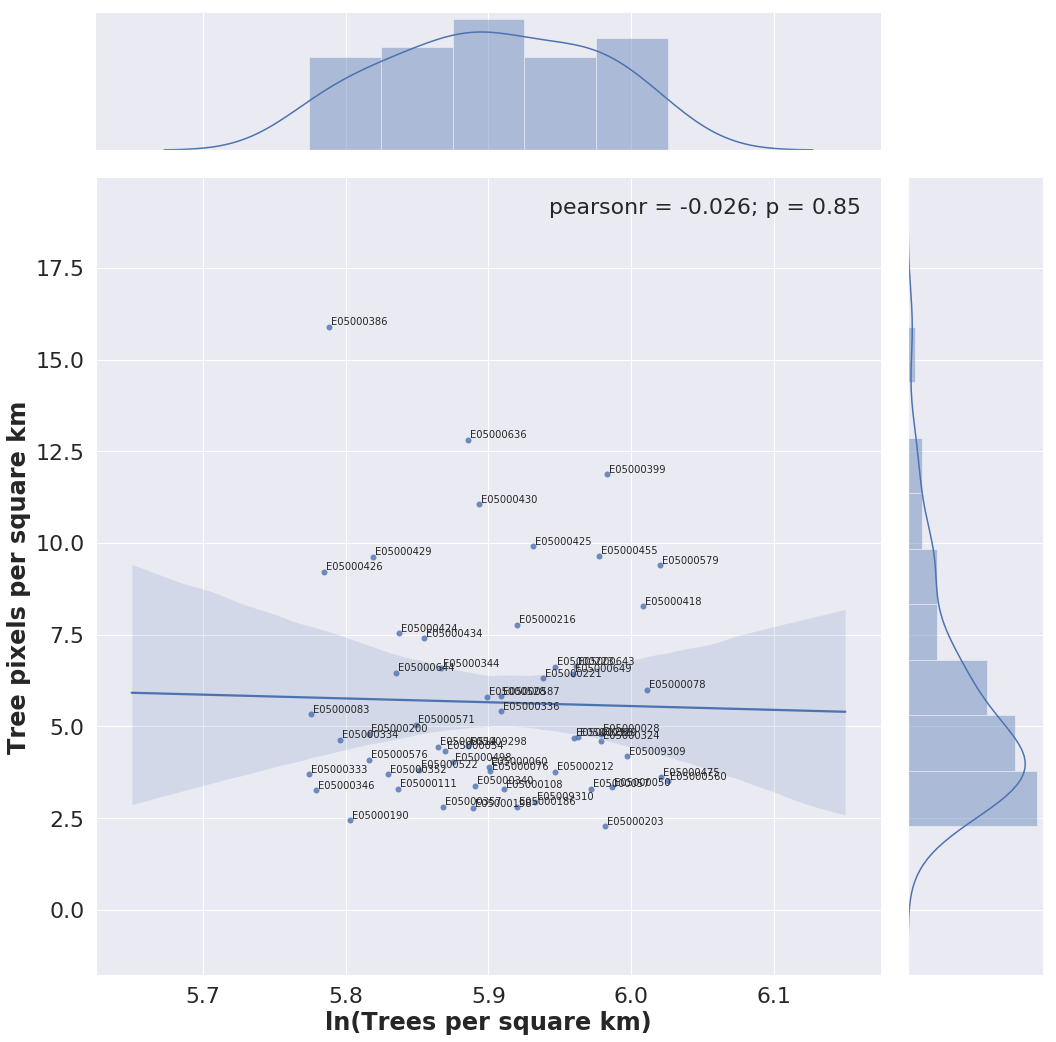

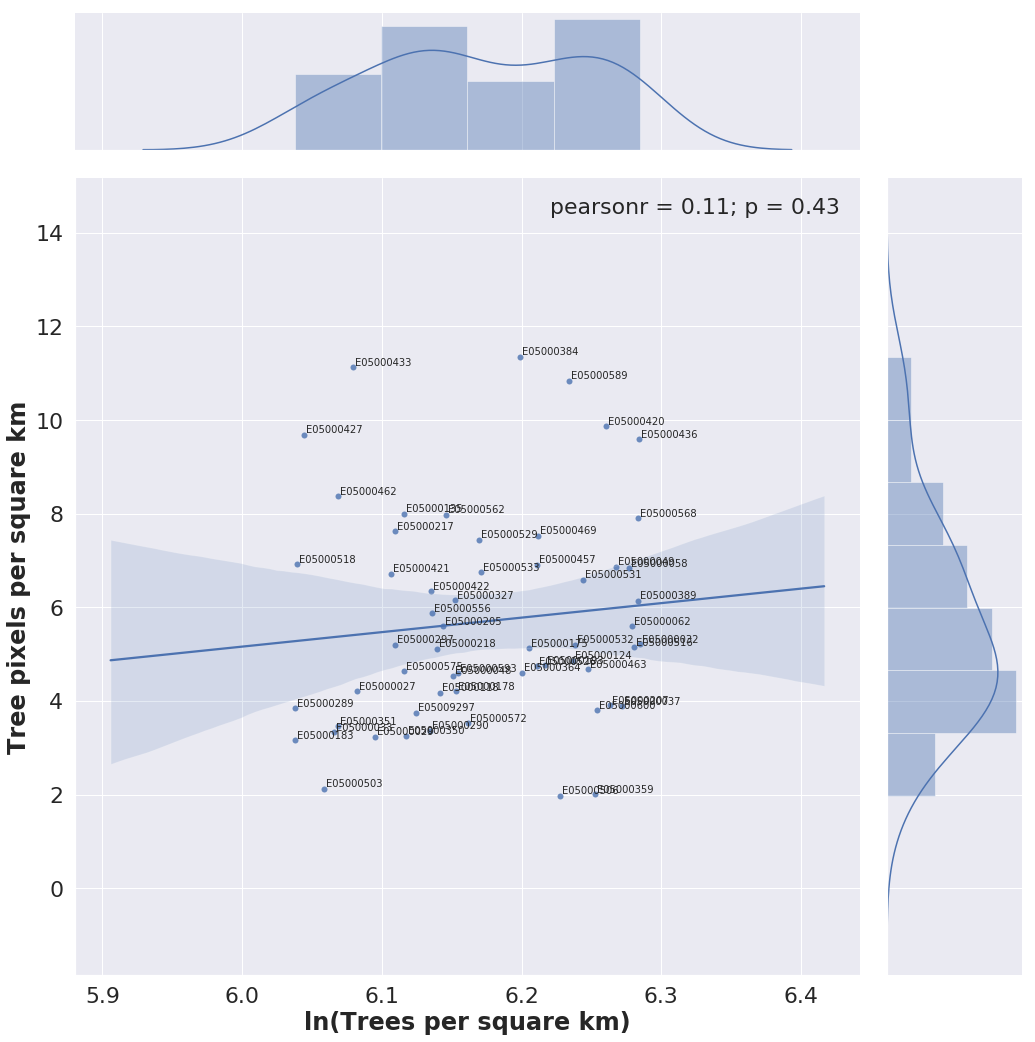

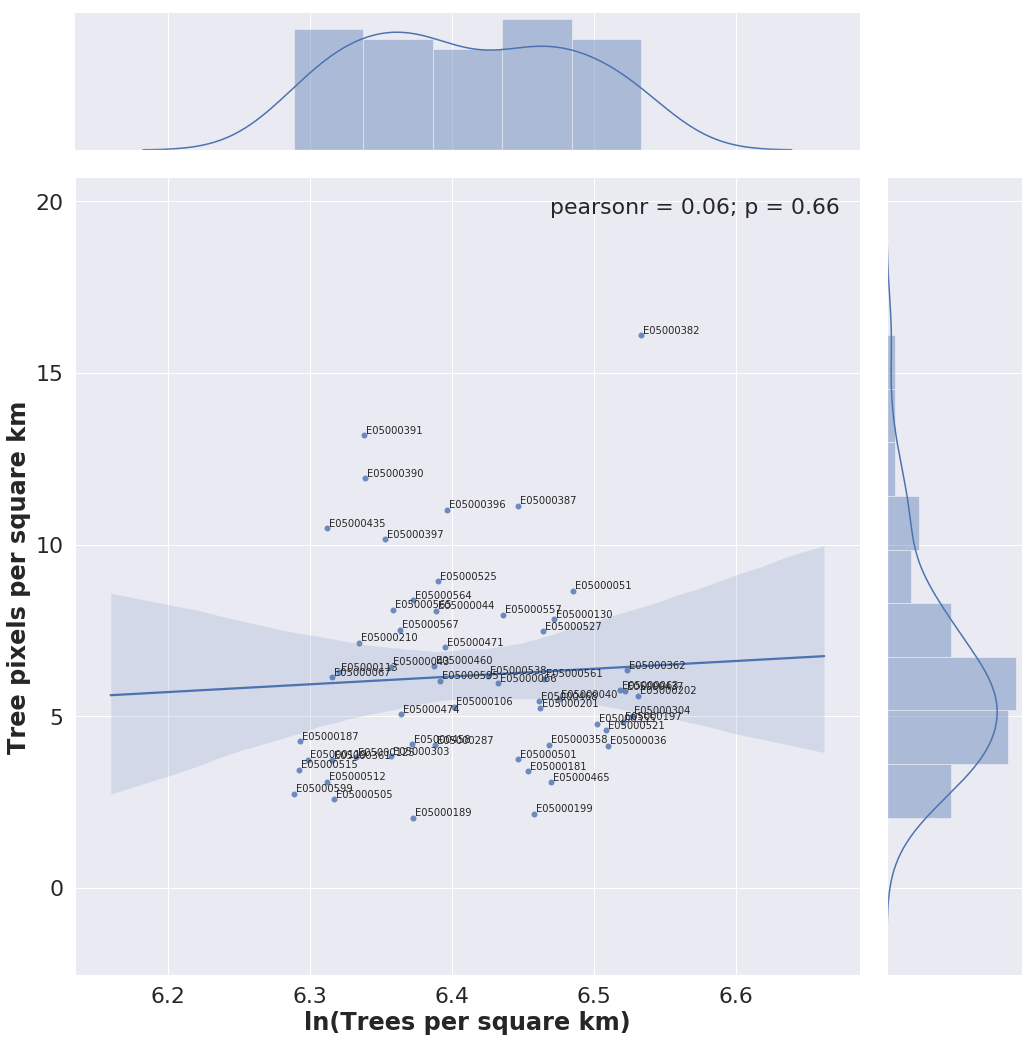

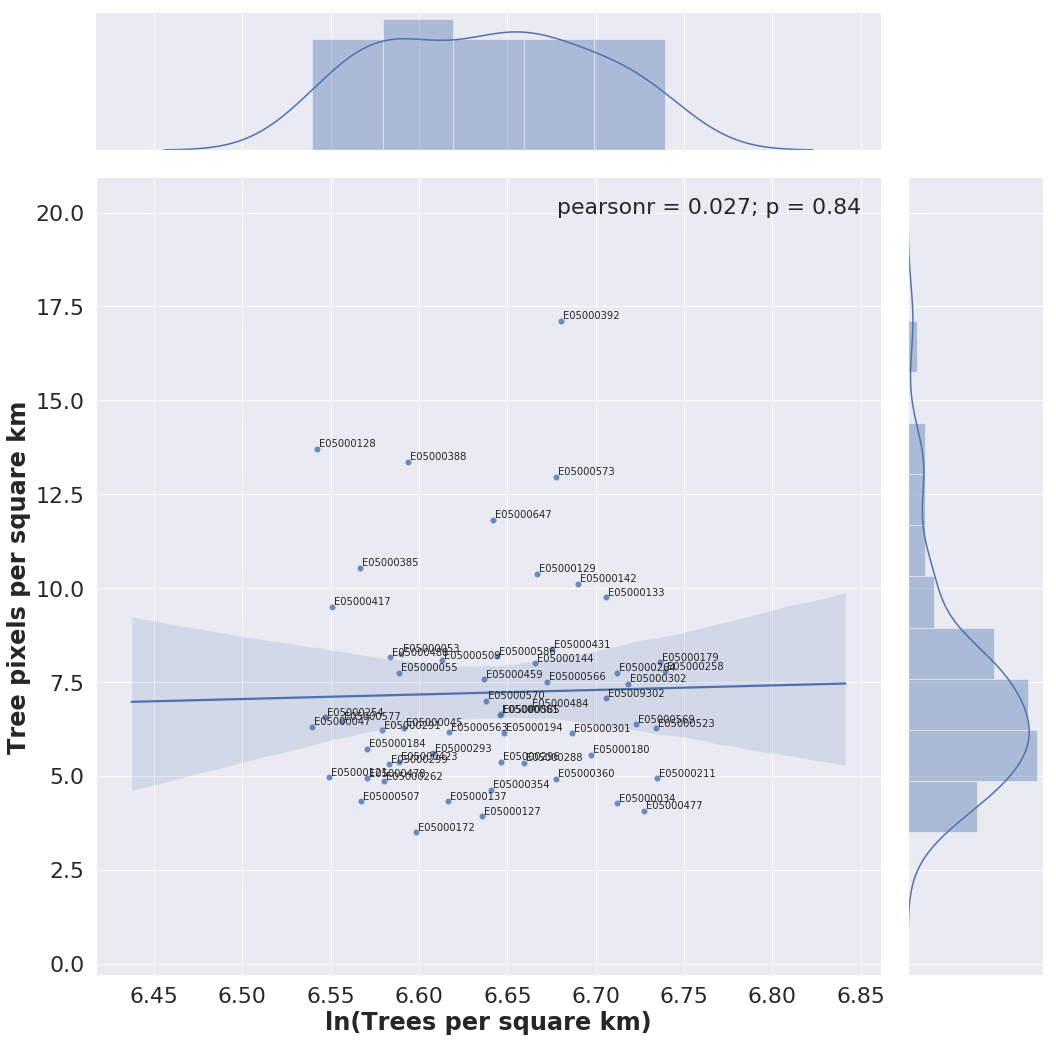

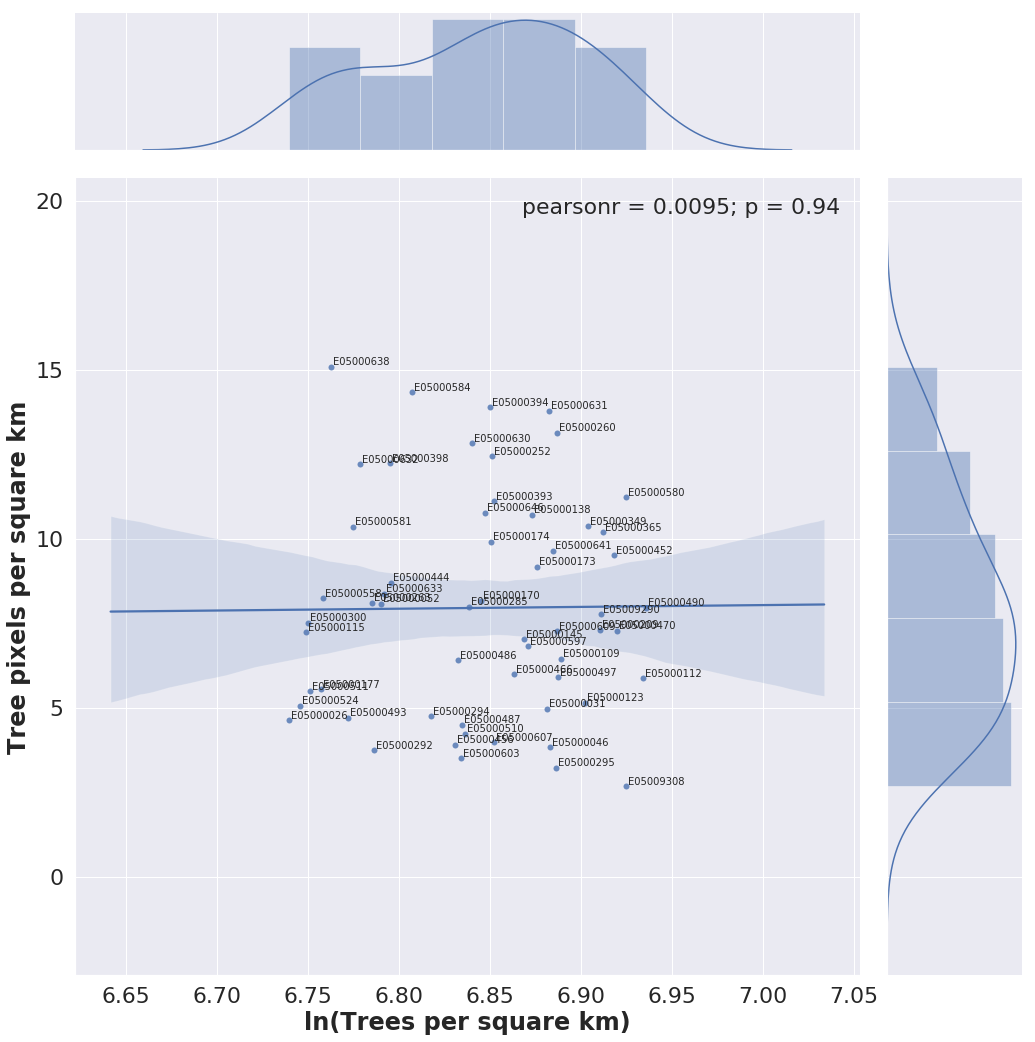

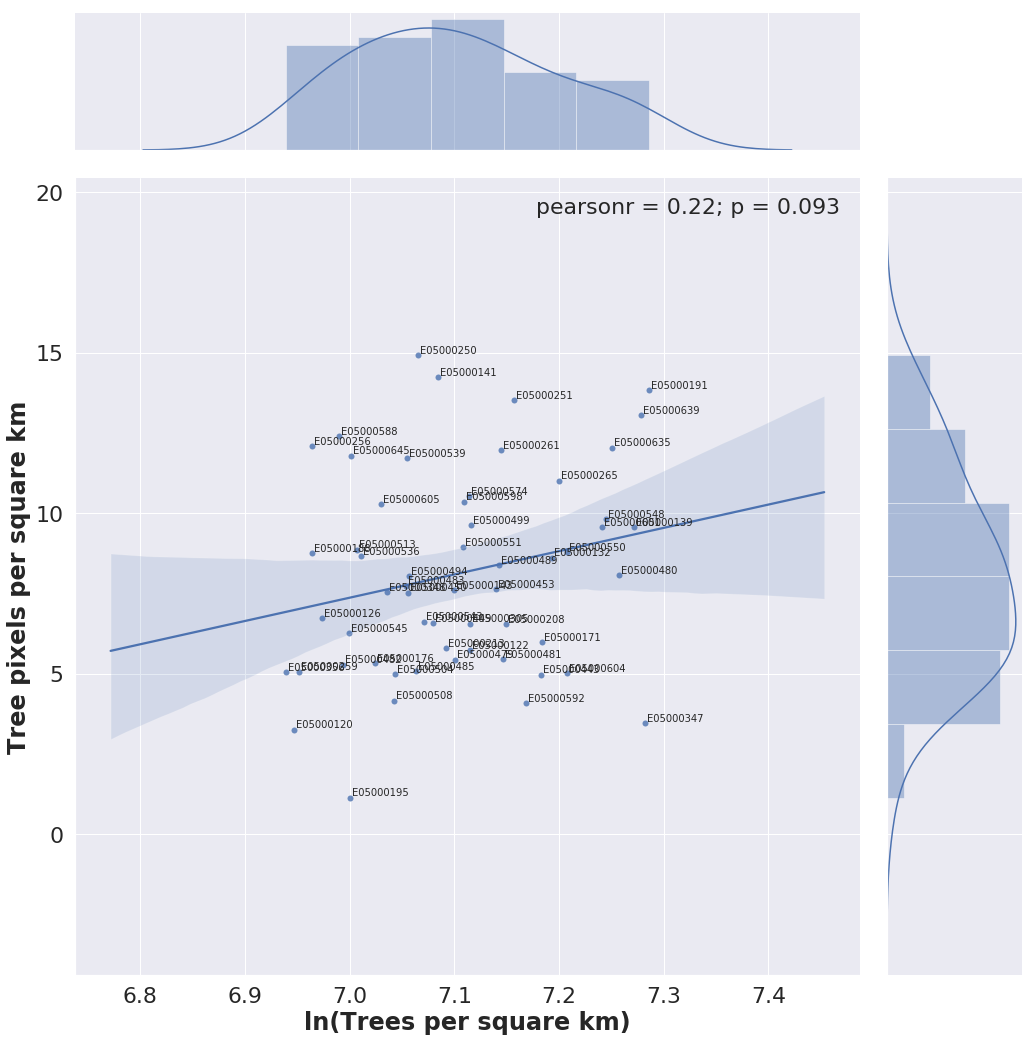

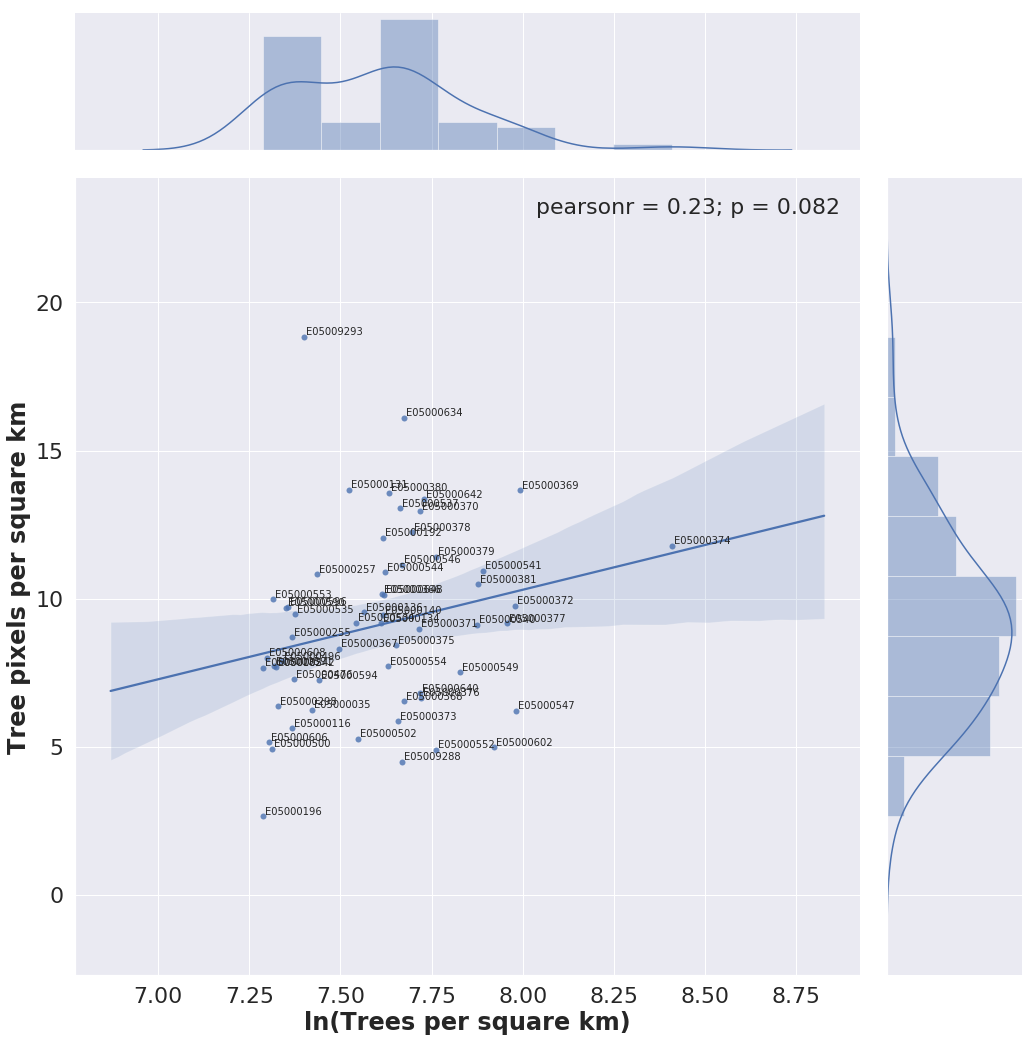

In [266]:
corrs_density = []
bins_density = []
for name, group in gdf.groupby('decile_treeDensity'):
    bins_density.append(name)
    corr = pearsonr(group['TreeDensity'],group['TreePixelDensity'])

    print corr
    sns.set(font_scale=2) 
    ax = sns.jointplot(x="TreeDensity", y="TreePixelDensity", data=group,kind='regression',height=15);
    plt.xlabel('ln(Trees per square km)')
    plt.ylabel('Tree pixels per square km')
    ax.annotate(pearsonr)
    for row in group.iterrows():
        ann(row)
    corrs_density.append(corr)

In [267]:
corrs_density

[(0.2638616914522597, 0.04535046709136969),
 (-0.1752736661112851, 0.19220223595703378),
 (-0.2134337121734116, 0.10768735066075176),
 (-0.026048943615417472, 0.8474752989800004),
 (0.10561260372351049, 0.4300986536424306),
 (0.05960913208357923, 0.6596034893375285),
 (0.02658410786545023, 0.8443802966164158),
 (0.009480027282804825, 0.9436941160705169),
 (0.22458549497718247, 0.09304509048101202),
 (0.22996444951013795, 0.08245955102834773)]

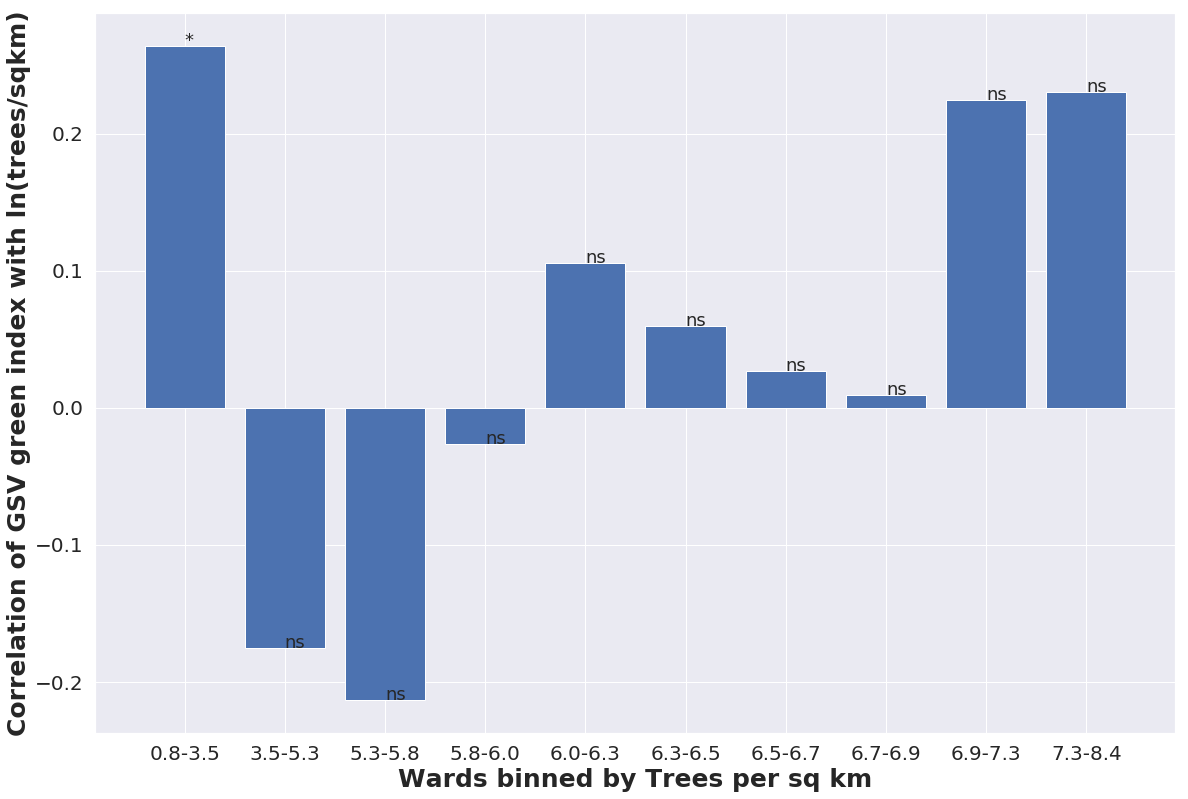

In [268]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Wards binned by Trees per sq km",fontsize = 25)
plt.ylabel("Correlation of GSV green index with ln(trees/sqkm)",fontsize = 25)
xlabels = [str(b.left)[:5]+'-'+str(b.right)[:5] for b in bins_density]
c = [corr[0] for corr in corrs_density]
ax.bar(xlabels,c)

p = []
for corr in corrs_density: 
    if corr[1] > 0.05:
        p.append('ns')
    elif corr[1] <= 0.05 and corr[1] > 0.01  :
        p.append('*')
    elif corr[1] <= 0.01 and corr[1] > 0.001:
        p.append('**')
    elif corr[1] <= 0.001 and corr[1] > 0.0001:
        p.append('**')
    elif corr[1] <= 0.0001 and corr[1] > 0.00001:
        p.append('***')
    else :
        p.append('****')
for xi, yi, l in zip(*[xlabels, c, p]):
    ax.text(xi, yi, l , fontsize = 18)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [269]:
wardpop = pd.read_csv('../Data/Geo_Data/housing-density-ward.csv')

In [270]:
wardpop = wardpop.rename(columns={'Code': 'borough_name'})

In [377]:
wardpop = wardpop[wardpop['Year']==2011]

In [378]:
ward_frame = gpd.read_file('../Data/Geo_Data/geo/london_wards.shp')

In [379]:
ward_frame.head()

,NAME,AREA_CODE,DESCRIPTIO,FILE_NAME,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,CODE,HECTARES,AREA,TYPE_CODE,DESCRIPT0,TYPE_COD0,DESCRIPT1,geometry
0,Chessington South Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,52,733,50840,10884,E05000405,755.173,0.0,VA,CIVIL VOTING AREA,,,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909..."
1,Tolworth and Hook Rise Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,106,734,117160,11407,E05000414,259.464,0.0,VA,CIVIL VOTING AREA,,,"POLYGON ((-0.30846 51.37586, -0.30834 51.37606..."
2,Berrylands Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,107,735,50449,11413,E05000401,145.390,0.0,VA,CIVIL VOTING AREA,,,"POLYGON ((-0.30385 51.39249, -0.30375 51.39252..."
3,Alexandra Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,108,736,50456,11420,E05000400,268.506,0.0,VA,CIVIL VOTING AREA,,,"POLYGON ((-0.26990 51.38845, -0.26975 51.38838..."
4,Beverley Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,109,737,117161,11417,E05000402,187.821,0.0,VA,CIVIL VOTING AREA,,,"POLYGON ((-0.24662 51.39921, -0.24672 51.39921..."


In [380]:
len(ward_frame)

649

In [381]:
population = wardpop[['borough_name','Population','Population_per_square_kilometre','Ward_Name']]

In [382]:
population_stats = pd.DataFrame.merge(ward_frame,population,left_on='CODE',right_on='borough_name',how='outer')

In [383]:
len(population_stats)

649

In [376]:
population_stats.to_csv('Ward_stats.csv')

In [74]:
tree = {}
tree_density = {}
tree_pixel_density = {}
pop_density = {}
pop = {}
names = []
for index, row in gdf.iterrows():
    wardname = row['borough_name']
    names.append(wardname)
    tree_density[wardname] = row['TreeDensity']
    tree[wardname] = row['TreeCount']
    tree_pixel_density[wardname] = row['TreePixelDensity']
    
for index,row in wardpop.iterrows():
    pop_density[row['borough_name']] = np.log10(row['Population_per_square_kilometre'])
    pop[row['borough_name']] = row['Population']
    
common =  set(wardpop['borough_name']).intersection(names)
        

In [76]:
# tree

In [78]:
# pop

In [79]:
tree_to_people_ratio = {} 
for k in pop:
    if k in tree:
        tree_to_people_ratio[k] = float(tree[k])/float(pop[k])

In [81]:
vals = np.log10(tree_to_people_ratio.values())
thresh_low = np.mean(vals) - np.sqrt(np.var(vals))
thresh_high = np.mean(vals) + np.sqrt(np.var(vals))

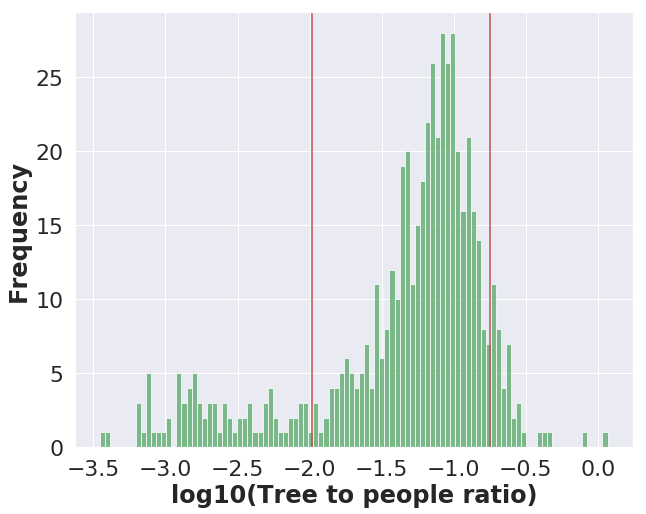

In [82]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('log10(Tree to people ratio)')
plt.ylabel('Frequency')
plt.axvline(thresh_low, color='r')
plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(np.log10(tree_to_people_ratio.values()), 100, facecolor='g', alpha=0.75)

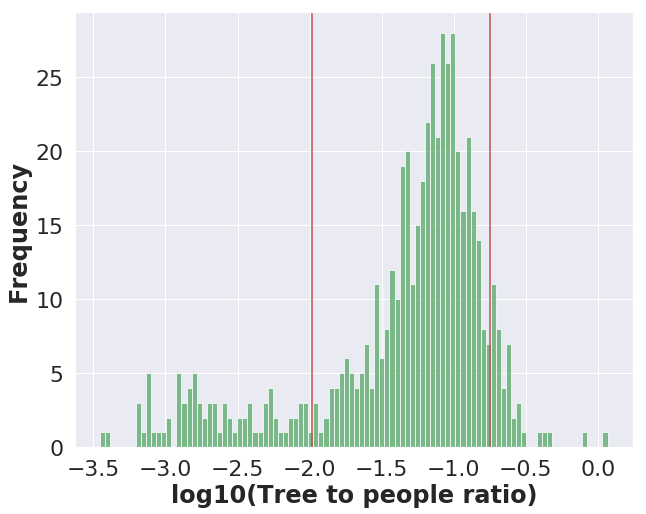

In [83]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('log10(Tree to people ratio)')
plt.ylabel('Frequency')
plt.axvline(thresh_low, color='r')
plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(np.log10(tree_to_people_ratio.values()), 100, facecolor='g', alpha=0.75)

In [84]:
filteredCommon = [k for k in common if np.log10(tree_to_people_ratio[k]) < thresh_high and  np.log10(tree_to_people_ratio[k]) > thresh_low ]

In [85]:
print [k for k in common if np.log10(tree_to_people_ratio[k]) > thresh_high or  np.log10(tree_to_people_ratio[k]) < thresh_low ]

['E05000266', 'E05000079', 'E05000247', 'E05000245', 'E05000244', 'E05000243', 'E05000242', 'E05000248', 'E05000547', 'E05000497', 'E05000149', 'E05000168', 'E05000167', 'E05000164', 'E05000163', 'E05000456', 'E05000280', 'E05000117', 'E05000116', 'E05000298', 'E05000111', 'E05000110', 'E05000291', 'E05000292', 'E05000118', 'E05000618', 'E05000594', 'E05000610', 'E05000611', 'E05000598', 'E05000614', 'E05000617', 'E05000202', 'E05000208', 'E05000509', 'E05000052', 'E05000372', 'E05000374', 'E05000627', 'E05000119', 'E05000621', 'E05000259', 'E05000623', 'E05000153', 'E05000620', 'E05000151', 'E05000622', 'E05000155', 'E05000629', 'E05000159', 'E05000158', 'E05000448', 'E05000322', 'E05000442', 'E05000445', 'E05000447', 'E05000438', 'E05000439', 'E05000613', 'E05000441', 'E05000440', 'E05000578', 'E05000269', 'E05000213', 'E05000405', 'E05000404', 'E05000406', 'E05000400', 'E05000065', 'E05000100', 'E05000103', 'E05000310', 'E05000314', 'E05000317', 'E05000316', 'E05000120', 'E05000281'

/usr/local/lib/python2.7/dist-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


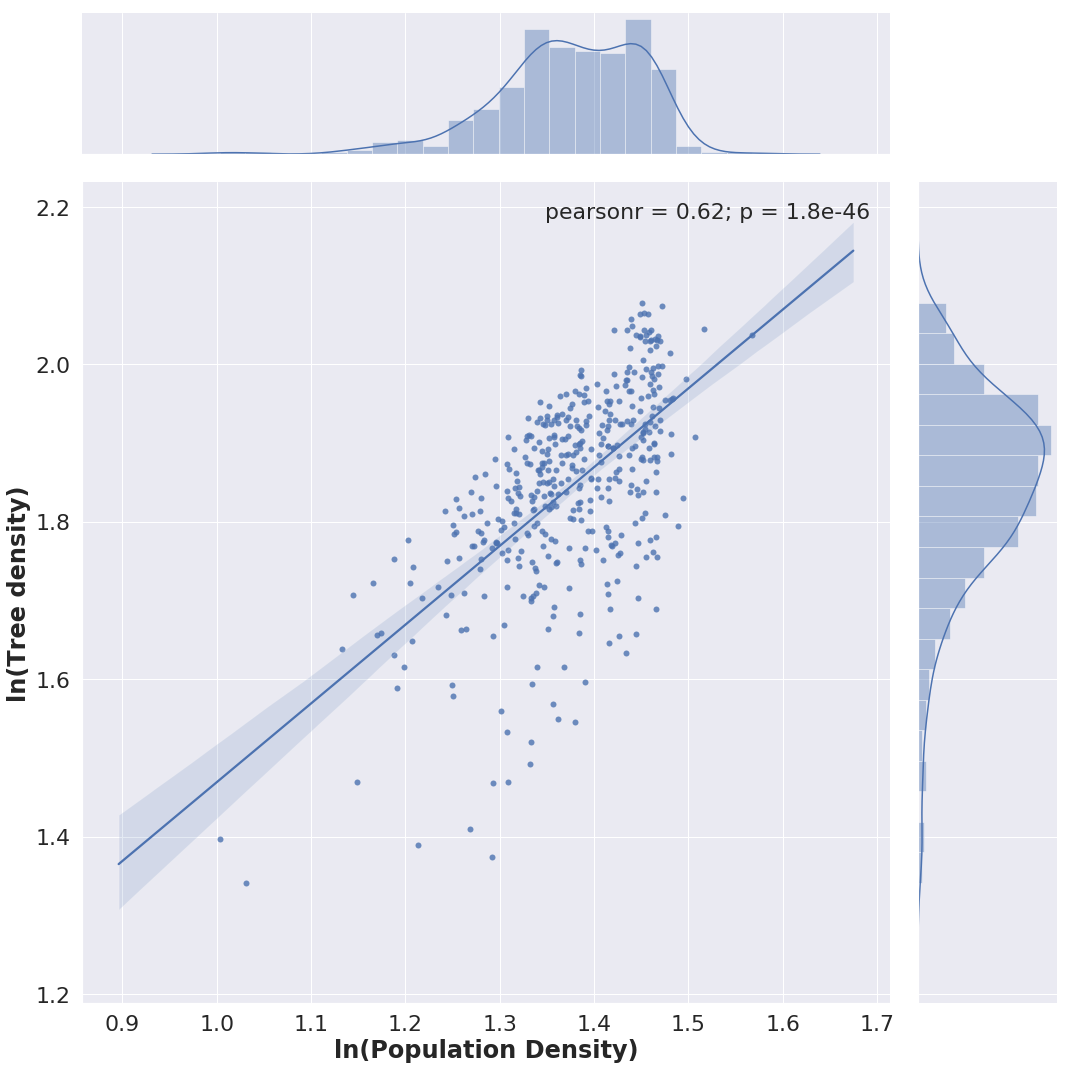

In [86]:
sns.set(font_scale=2) 
ax = sns.jointplot(x=[np.log(pop_density[k]) for k in filteredCommon] , y=[np.log(tree_density[k]) for k in filteredCommon],kind='regression',height=15);
plt.xlabel('ln(Population Density)')
plt.ylabel('ln(Tree density)')
ax.annotate(pearsonr)

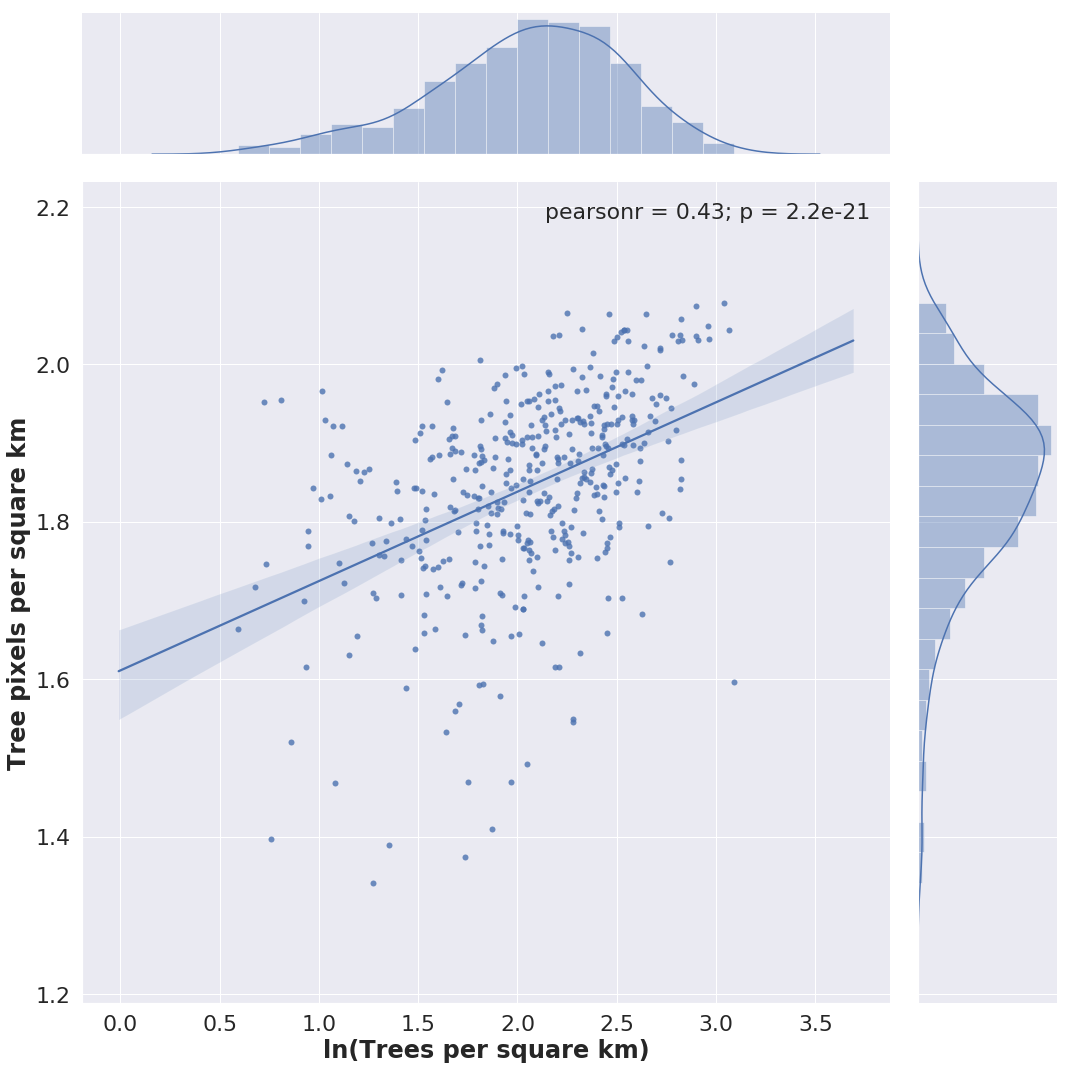

In [87]:
sns.set(font_scale=2) 
ax = sns.jointplot(x=[np.log(tree_pixel_density[k]) for k in filteredCommon] , y=[np.log(tree_density[k]) for k in filteredCommon],kind='regression',height=15);
plt.xlabel('ln(Trees per square km)')
plt.ylabel('Tree pixels per square km')
ax.annotate(pearsonr)

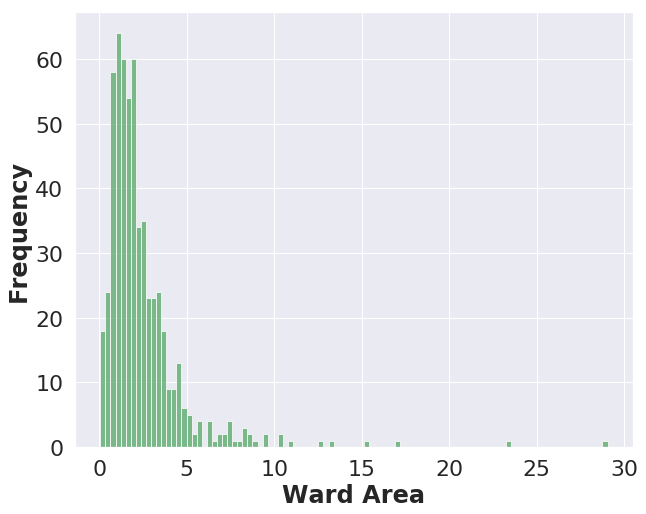

In [88]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Ward Area')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['area_km']/10.0, 100, facecolor='g', alpha=0.75)

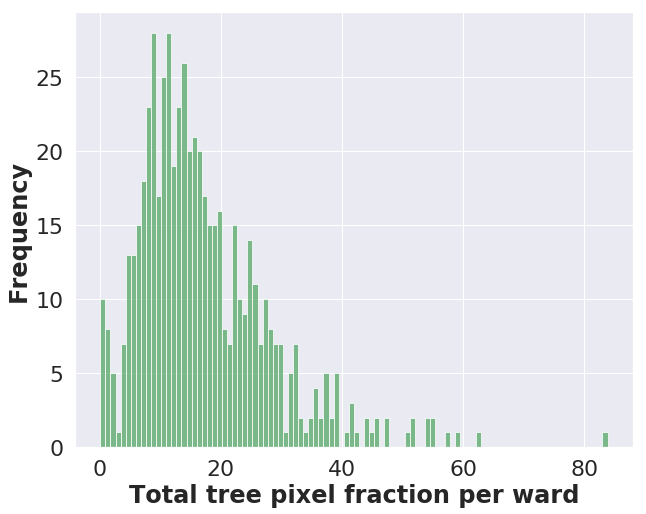

In [89]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Total tree pixel fraction per ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreeTotal'], 100, facecolor='g', alpha=0.75)

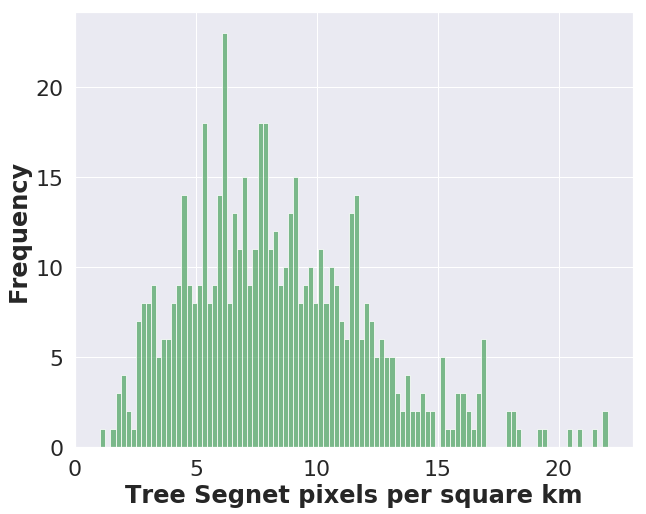

In [90]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Tree Segnet pixels per square km')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreePixelDensity'], 100, facecolor='g', alpha=0.75)

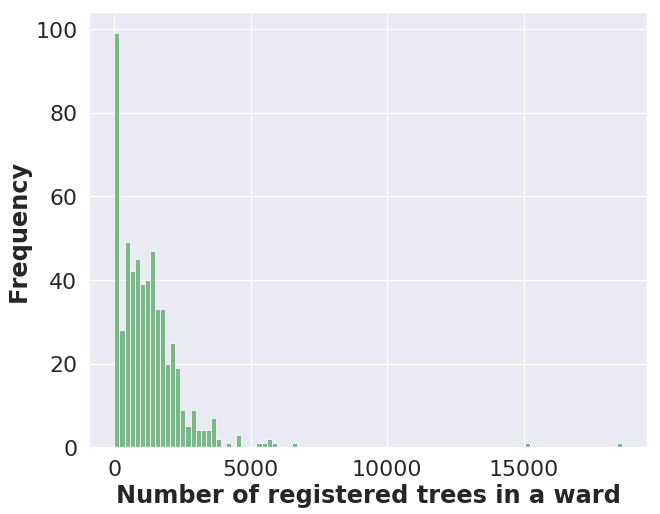

In [91]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Number of registered trees in a ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreeCount'], 100, facecolor='g', alpha=0.75)

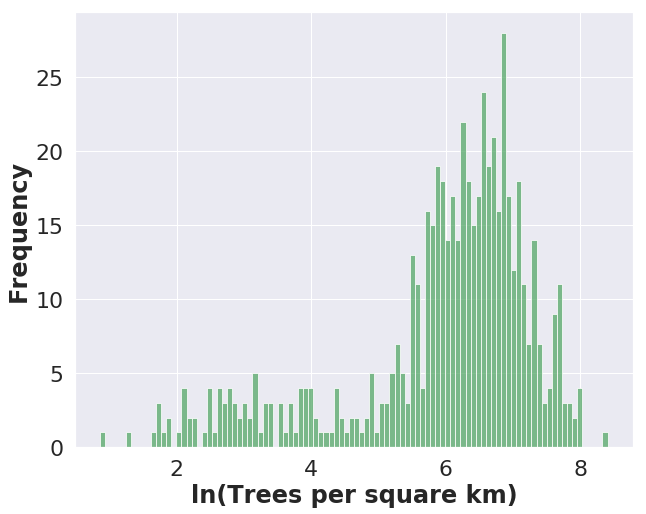

In [92]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('ln(Trees per square km)')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreeDensity'], 100, facecolor='g', alpha=0.75)

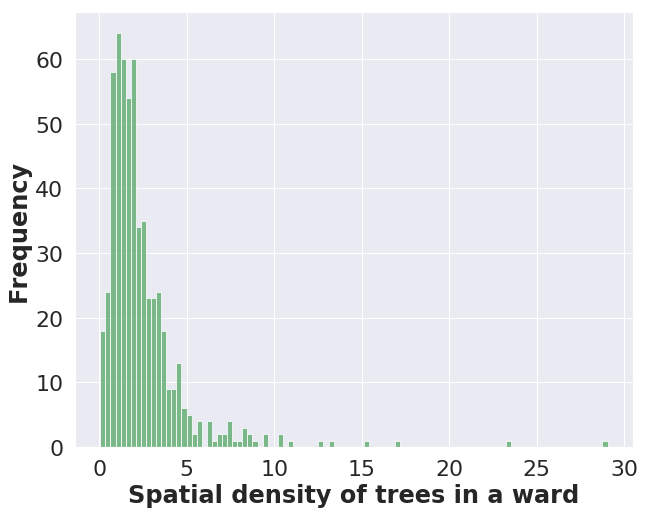

In [93]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Spatial density of trees in a ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['area_km']/10, 100, facecolor='g', alpha=0.75)

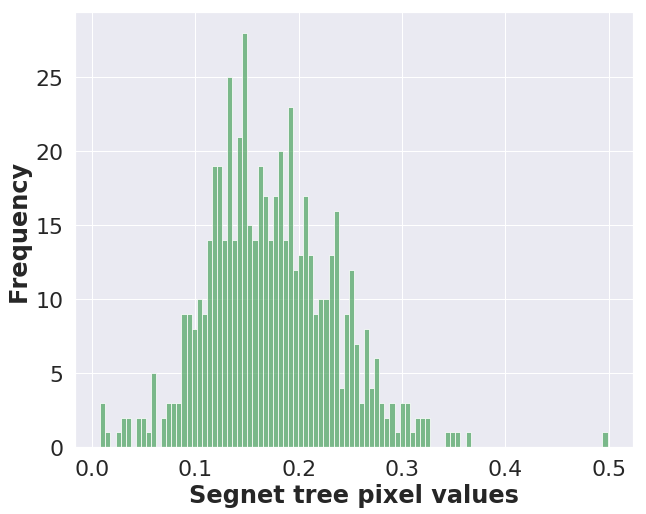

In [94]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Segnet tree pixel values')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['Tree'], 100, facecolor='g', alpha=0.75)

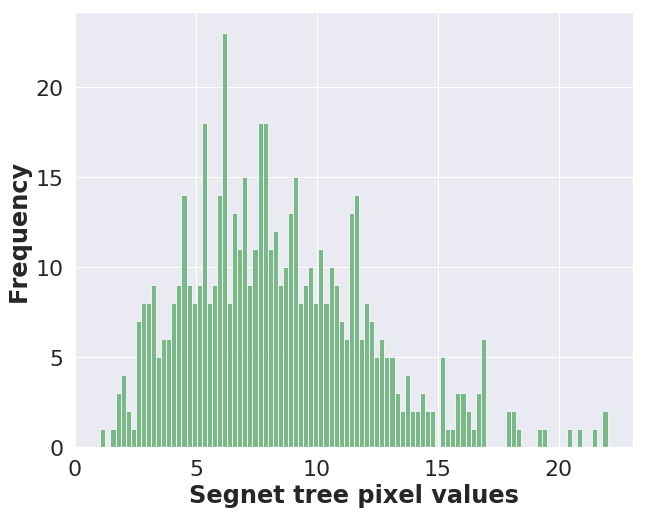

In [95]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Segnet tree pixel values')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreePixelDensity'], 100, facecolor='g', alpha=0.75)

(-0.04776208015370095, 0.2528497988179577)


Text(3000,5e-05,'Pearson r: -0.04***')

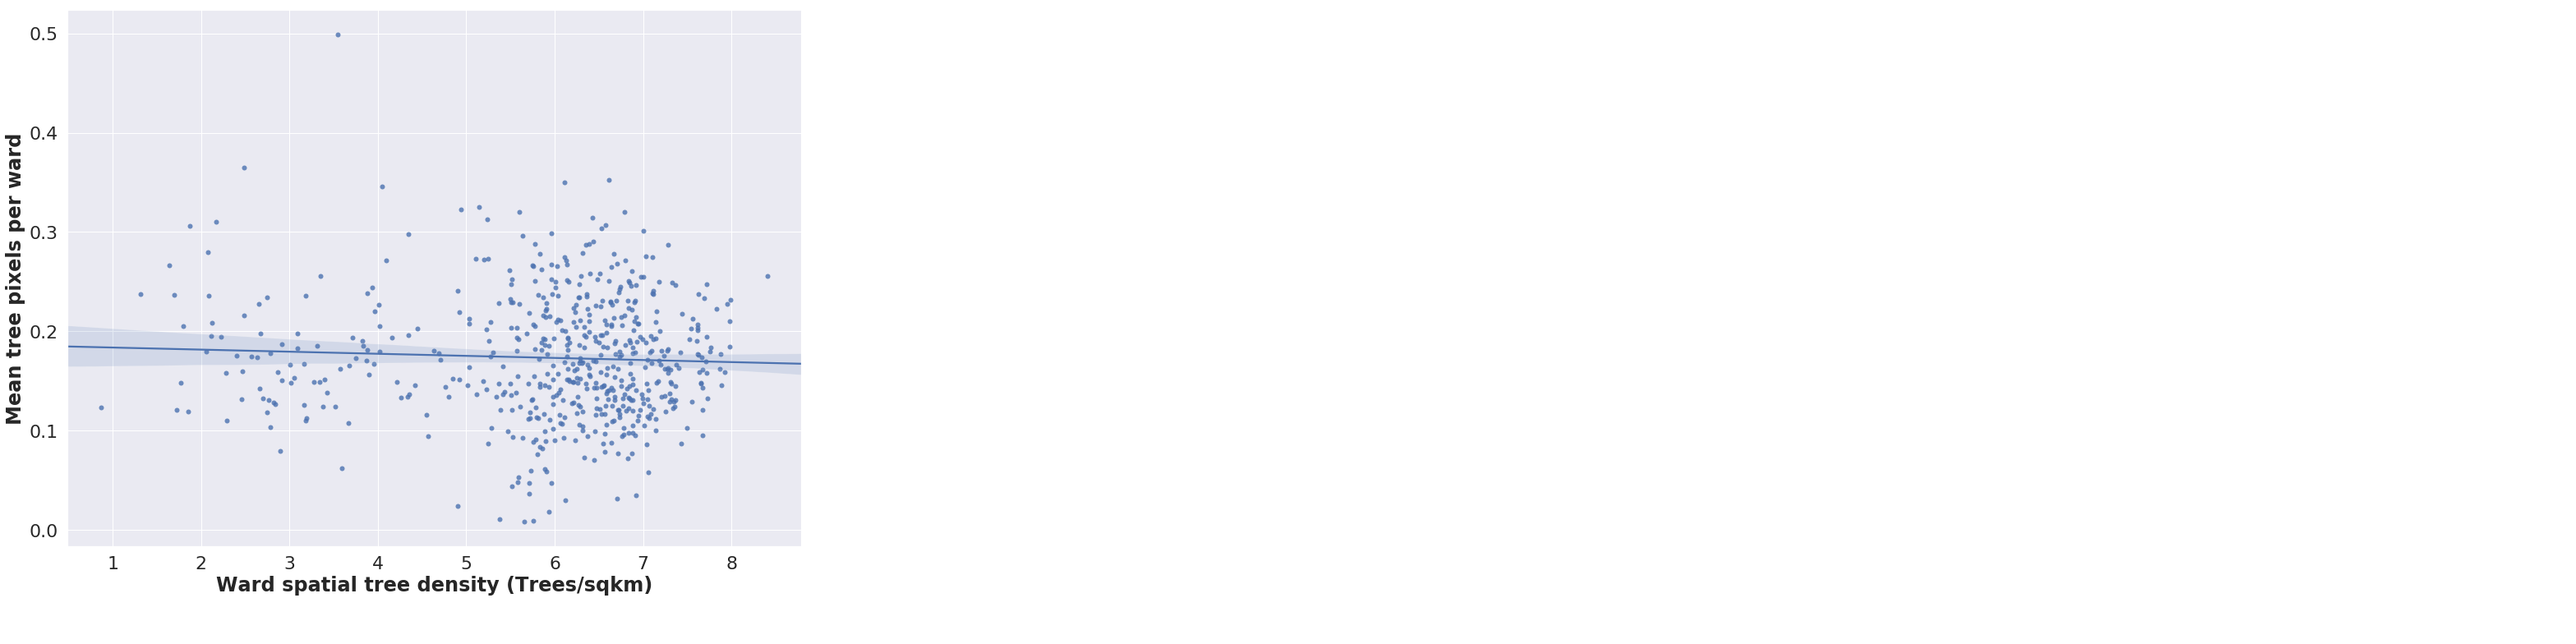

In [96]:
corr = pearsonr(gdf['TreeDensity'],gdf['Tree'])
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="TreeDensity", y="Tree", data=gdf);
plt.xlabel('Ward spatial tree density (Trees/sqkm)')
plt.ylabel('Mean tree pixels per ward')
ax.annotate("Pearson r: " +  str(corr[0])[:5] + '***',  xy=(3000, 0.00005),fontsize = 20)

(-0.0383039838312331, 0.35922909905556355)


Text(2,-3,'Pearson r: -0.0***')

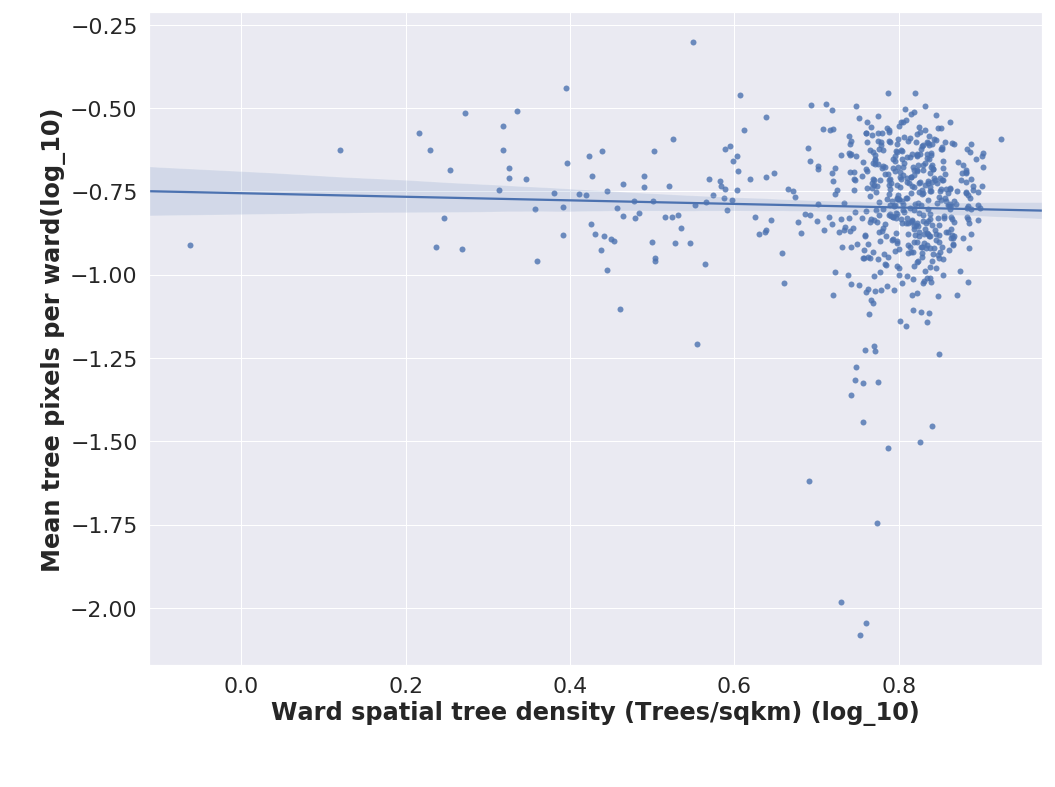

In [97]:
corr = pearsonr(np.log10(gdf['TreeDensity']),np.log10(gdf['Tree']))
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x=np.log10(gdf['TreeDensity']), y=np.log10(gdf['Tree']));
plt.xlabel('Ward spatial tree density (Trees/sqkm) (log_10)')
plt.ylabel('Mean tree pixels per ward(log_10)')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(2, -3 ),fontsize = 20)

In [98]:
min(gdf['TreeCount'])

10

In [99]:
#Work with merging wards 
Wards_LSOA_2001 = pd.read_csv('../../BL_Work/WardMaps/Lower_Layer_Super_Output_Area_2001_to_Ward_2001_Lookup_in_England_and_Wales.csv')
Wards_LSOA_2011 = pd.read_csv('../../BL_Work/WardMaps/Lower_Layer_Super_Output_Area_2001_to_Ward_2011_Lookup_in_England_and_Wales.csv')

In [100]:
merged_Wards_LSOA = pd.merge(Wards_LSOA_2001, Wards_LSOA_2011, on='LSOA01CD', how='outer')

In [101]:
# merged_Wards_LSOA.to_csv('Merged_wards_LSOA_2001_2011.csv')
merged_Wards_LSOA.head()

,LSOA01CD,LSOA01NM_x,WD01CD,WD01NM,FID_x,LSOA01NM_y,WD11CD,WD11CDO,WD11NM,FID_y
0,E01012101,Redcar and Cleveland 001B,00EEMC,Coatham,12001,Redcar and Cleveland 001B,E05001506,00EENA,Coatham,12019
1,E01012351,Darlington 004C,00EHMW,North Road,12002,Darlington 004C,E05001571,00EHNX,North Road,12008
2,E01012102,Redcar and Cleveland 001C,00EEMC,Coatham,12003,Redcar and Cleveland 001C,E05001506,00EENA,Coatham,12023
3,E01012352,Darlington 004D,00EHMW,North Road,12004,Darlington 004D,E05001571,00EHNX,North Road,12010
4,E01012353,Darlington 008B,00EHMU,Northgate South,12005,Darlington 008B,E05001572,00EHNY,Northgate,12011


In [103]:
ward_csv_CRESH = pd.read_csv('../Data/Geo_Data//uk_ward_greenspace.csv')

In [104]:
ward_csv_CRESH.head()

,casward2001,greenspace_pc
0,00AAFA,8.383184
1,00AAFE,24.354640
2,00AAFQ,10.795210
3,00AAFS,22.745890
4,00AAFT,22.767050


In [105]:
WardMap = {}
for index , row in merged_Wards_LSOA.iterrows():
    WardMap[row['WD11CDO']] = row['WD11CD']

In [106]:
len(WardMap)

8541

In [173]:
# json.dump(WardMap , open("CAS_NEW_WARD_MAPPING.json",'w'))

In [107]:
len(set(ward_csv_CRESH['casward2001']).intersection(list(merged_Wards_LSOA['WD11CDO'])))

6492

In [108]:
MedIx_score_wards = {}
CAS_New_Map = {}
for index,row in ward_csv_CRESH.iterrows():
    old = row ['casward2001']
    if old in WardMap:
        CAS_New_Map[old] = 
        MedIx_score_wards[WardMap[old]] = row['greenspace_pc']

In [109]:
MedIx_score_wards

{'E05007637': 64.11626,
 'E05007636': 43.51981,
 'E05007635': 30.7807,
 'E05007634': 43.466809999999995,
 'E05007244': 41.271409999999996,
 'E05007633': 37.34624,
 'E05007245': 84.8492,
 'E05007632': 33.36373,
 'E05003228': 59.47501,
 'E05003229': 70.89026,
 'E05007631': 37.52205,
 'E05003220': 95.15514,
 'E05003221': 95.01016,
 'E05003222': 94.86084,
 'E05003223': 94.25721,
 'E05003224': 83.99558,
 'E05003225': 35.33044,
 'E05003226': 91.5726,
 'E05003227': 60.21801,
 'E05007249': 91.24110999999999,
 'E05002281': 20.372770000000003,
 'E05000420': 8.91957,
 'W05000443': 59.71256999999999,
 'W05000442': 71.6068,
 'W05000441': 65.13468,
 'W05000440': 58.25966999999999,
 'W05000447': 94.14062,
 'E05007302': 92.41017,
 'W05000445': 93.1222,
 'W05000444': 85.98912,
 'W05000449': 90.75399999999999,
 'W05000448': 93.7774,
 'E05007309': 68.53757,
 'E05007308': 79.09637,
 'W05000911': 19.6979,
 'W05000910': 91.20264,
 'W05000913': 76.46718,
 'W05000912': 27.914270000000002,
 'W05000915': 47.294

In [110]:
# %store MedIx_score_wards

In [111]:
json.dump(MedIx_score_wards,open('Ward_index_deprivation.json','wb'))

In [132]:
GLUD_green = pd.read_csv('../../BL_Work/london_wards_green_pixels_average.csv')

In [133]:
GLUD_green.head()

,GSS_CODE,tree_pixels,grass_pixels,urban_pixels,npix,tree_pct,grass_pct,urban_pct
0,E05000026,26,70,2638,2828.0,0.009194,0.024752,0.932815
1,E05000027,0,424,2634,3069.0,0.000000,0.138156,0.858260
2,E05000028,0,369,2631,3002.0,0.000000,0.122918,0.876416
3,E05000029,34,1501,3422,8078.0,0.004209,0.185813,0.423620
4,E05000030,202,1958,3871,6704.0,0.030131,0.292064,0.577416


In [134]:
MedixDf = pd.DataFrame.from_dict(MedIx_score_wards,orient='index')
MedixDf['GSS_CODE'] = MedixDf.index
MedixDf = MedixDf.rename(columns={0: 'green_score'})

In [135]:
MedixDf.head()


,green_score,GSS_CODE
E05007637,64.11626,E05007637
E05007636,43.51981,E05007636
E05007635,30.78070,E05007635
E05007634,43.46681,E05007634
E05007244,41.27141,E05007244


In [136]:
len(MedixDf)

6492

In [137]:
MergedGLUD = pd.merge(MedixDf, GLUD_green, on='GSS_CODE')

In [138]:
MergedGLUD.head()

,green_score,GSS_CODE,tree_pixels,grass_pixels,urban_pixels,npix,tree_pct,grass_pct,urban_pct
0,8.91957,E05000420,0,0,2387,2387.0,0.000000,0.000000,1.000000
1,41.70052,E05000571,126,391,2999,4085.0,0.030845,0.095716,0.734149
2,18.26981,E05000570,28,180,3339,3717.0,0.007533,0.048426,0.898305
3,27.56138,E05000572,60,540,3284,3964.0,0.015136,0.136226,0.828456
4,41.44914,E05000620,93,214,4834,6408.0,0.014513,0.033396,0.754370


(0.7748603202474922, 7.236422420065398e-98)


Text(29,0.25,'Pearson r: 0.77***')

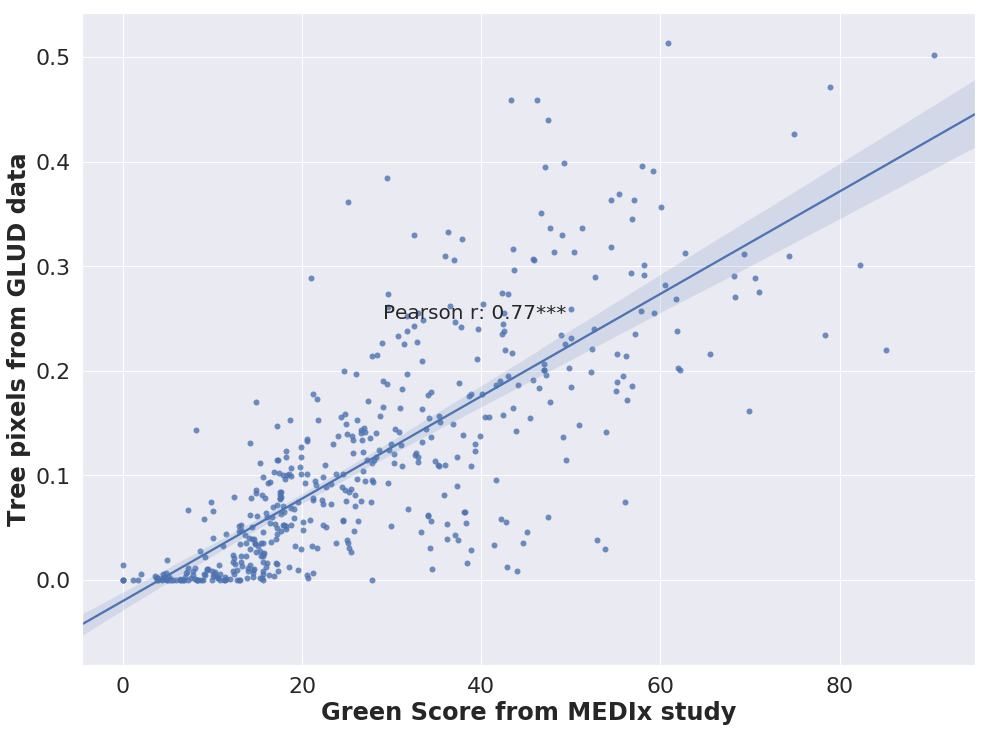

In [155]:
corr = pearsonr(MergedGLUD['green_score'],MergedGLUD['grass_pct'])
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="green_score", y="grass_pct", data=MergedGLUD);
plt.xlabel('Green Score from MEDIx study')
plt.ylabel('Tree pixels from GLUD data')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(29, 0.25),fontsize = 20)

In [142]:
Df = pd.read_pickle('Ward_mapillary.pkl')

In [143]:
Df.head()

,borough_name,poly,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Sky,SkyTotal,...,Fence,FenceTotal,Vehicle,VehicleTotal,Pedestrian,PedestrianTotal,Bike,BikeTotal,Tree_location_list,TreeCount
21,Purley Ward,"POLYGON ((25964.668 7168.071, 25960.166 7200.9...",4.178263e+06,41.782628,"[POINT (28832.56486369937 7689.604028513859), ...","[[0.280966435185, 0.00344328703704, 0.00028935...","[0.40477077687443547, 0.05154513888888887, 0.0...","[16.595601851851853, 2.113350694444444, 0.1145...",0.404771,16.595602,...,0.015565,0.638166,0.048554,1.990694,0.000276,0.011325,0.000781,0.032020,"[POINT (27902.53168313735 7418.578601421934), ...",119
24,Fairfield Ward,"POLYGON ((31467.192 11278.816, 31489.501 11215...",3.775024e+06,37.750241,"[POINT (28780.23788984926 11484.78060723547), ...","[[0.187366898148, 0.289571759259, 0.0186863425...","[0.13047026791135383, 0.34295721387370987, 0.0...","[119.38029513888874, 313.80585069444453, 14.05...",0.130470,119.380295,...,0.016739,15.315926,0.051595,47.209595,0.030289,27.714340,0.001546,1.414896,"[POINT (29187.091910555 10769.32604198882), PO...",242
28,Norbury Ward,"POLYGON ((27575.239 14109.150, 27532.723 14080...",2.520055e+06,25.200553,"[POINT (27636.15980677991 14970.52663833459), ...","[[0.41224537037, 0.210133101852, 0.00146990740...","[0.3571611952861953, 0.1357530162738496, 0.001...","[11.786319444444445, 4.479849537037037, 0.0617...",0.357161,11.786319,...,0.044785,1.477917,0.086356,2.849763,0.000726,0.023958,0.000094,0.003113,"[POINT (27554.47115820904 14154.27245751224), ...",107
32,Shirley Ward,"POLYGON ((31903.153 11588.332, 31904.153 11606...",2.807491e+06,28.074913,"[POINT (33161.4227536371 11911.89713691166), P...","[[0.468946759259, 0.0306423611111, 0.002106481...","[0.30857958698830407, 0.03883200840643272, 0.0...","[23.45204861111111, 2.9512326388888868, 0.5463...",0.308580,23.452049,...,0.022710,1.725984,0.039777,3.023050,0.000897,0.068137,0.001912,0.145341,"[POINT (33963.95718836391 11740.90841724121), ...",144
40,Darwin Ward,"POLYGON ((41850.576 2242.806, 41846.875 2241.4...",2.906118e+07,290.611780,"[POINT (39877.43297735744 7619.139160307794), ...","[[0.071400462963, 0.0683796296296, 0.001336805...","[0.09961807031840511, 0.02757815452569917, 0.0...","[39.050283564814805, 10.810636574074074, 1.154...",0.099618,39.050284,...,0.008956,3.510781,0.156454,61.329792,0.000766,0.300336,0.000492,0.192760,"[POINT (38007.87818382602 6908.537118675158), ...",1011


In [144]:
gdf_Df = gpd.GeoDataFrame(Df, geometry='poly', crs={'init': 'epsg:4326'})

In [145]:
gdf.head()

,borough_name,poly,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Sky,SkyTotal,...,BikeTotal,Tree_location_list,TreeCount,NormedTreeCount,NormedTreeSegnet,TreeDensity,TreePixelDensity,GSV_samples_per_sqkm,decile,decile_treeDensity
0,E05000405,"POLYGON ((13004.069 5643.557, 13009.772 5652.2...",7.557384e+06,75.573841,"[POINT (14125.90147603366 8949.628961333685), ...","[[0.248032407407, 0.248420138889, 0.0088773148...","[0.3045318680330815, 0.13717390327220425, 0.00...","[31.3667824074074, 14.128912037037038, 0.80149...",0.304532,31.366782,...,0.100023,"[POINT (14517.9631249908 9426.159779180685), P...",91,0.004361,0.423326,2.488334,2.942247,13,"(3.0, 24.0]","(0.8, 3.5]"
1,E05000414,"POLYGON ((14432.579 10890.807, 14440.082 10913...",2.596590e+06,25.965904,"[POINT (15785.12071092852 10683.26380937701), ...","[[0.321105324074, 0.175827546296, 0.0061111111...","[0.29897431657848317, 0.17237064594356266, 0.0...","[31.392303240740734, 18.09891782407408, 1.1074...",0.298974,31.392303,...,0.102911,"[POINT (16576.51872432181 10953.0350912103), P...",53,0.002315,0.285821,3.016093,6.002971,40,"(37.0, 41.0]","(0.8, 3.5]"
3,E05000400,"POLYGON ((17083.956 12354.060, 17094.660 12346...",2.687010e+06,26.870103,"[POINT (16861.33974843501 10669.48940821065), ...","[[0.226550925926, 0.00512731481481, 7.52314814...","[0.3125163152610444, 0.12744589468987064, 0.01...","[25.938854166666683, 10.578009259259263, 1.035...",0.312516,25.938854,...,0.086128,"[POINT (16524.99709356503 11497.43654827776), ...",74,0.003446,0.360819,3.315636,5.721577,30,"(24.0, 31.0]","(0.8, 3.5]"
5,E05000406,"POLYGON ((18612.114 14742.451, 18536.285 14807...",4.424962e+06,44.249620,"[POINT (17891.20284518503 17546.77887998099), ...","[[0.374577546296, 0.0157349537037, 0.011232638...","[0.4812529906164558, 0.061979904610986826, 0.0...","[71.70669560185192, 9.235005787037037, 0.91114...",0.481253,71.706696,...,0.097963,"[POINT (18401.57420806239 15390.48764707943), ...",64,0.002907,0.387214,2.671621,6.672953,33,"(31.0, 37.0]","(0.8, 3.5]"
6,E05000404,"POLYGON ((13778.042 9520.497, 13768.138 9631.5...",1.931236e+06,19.312361,"[POINT (14386.05607928922 9663.164811627386), ...","[[0.372355324074, 0.14150462963, 0.01096064814...","[0.30126322751322754, 0.1703617273929774, 0.00...","[23.19726851851852, 13.117853009259258, 0.6581...",0.301263,23.197269,...,0.097743,"[POINT (14505.65813167962 9519.194190858543), ...",39,0.001561,0.322304,3.005401,6.632152,39,"(37.0, 41.0]","(0.8, 3.5]"


(0.2316385071301671, 1.920558683456572e-08)


Text(29,0.25,'Pearson r: 0.23***')

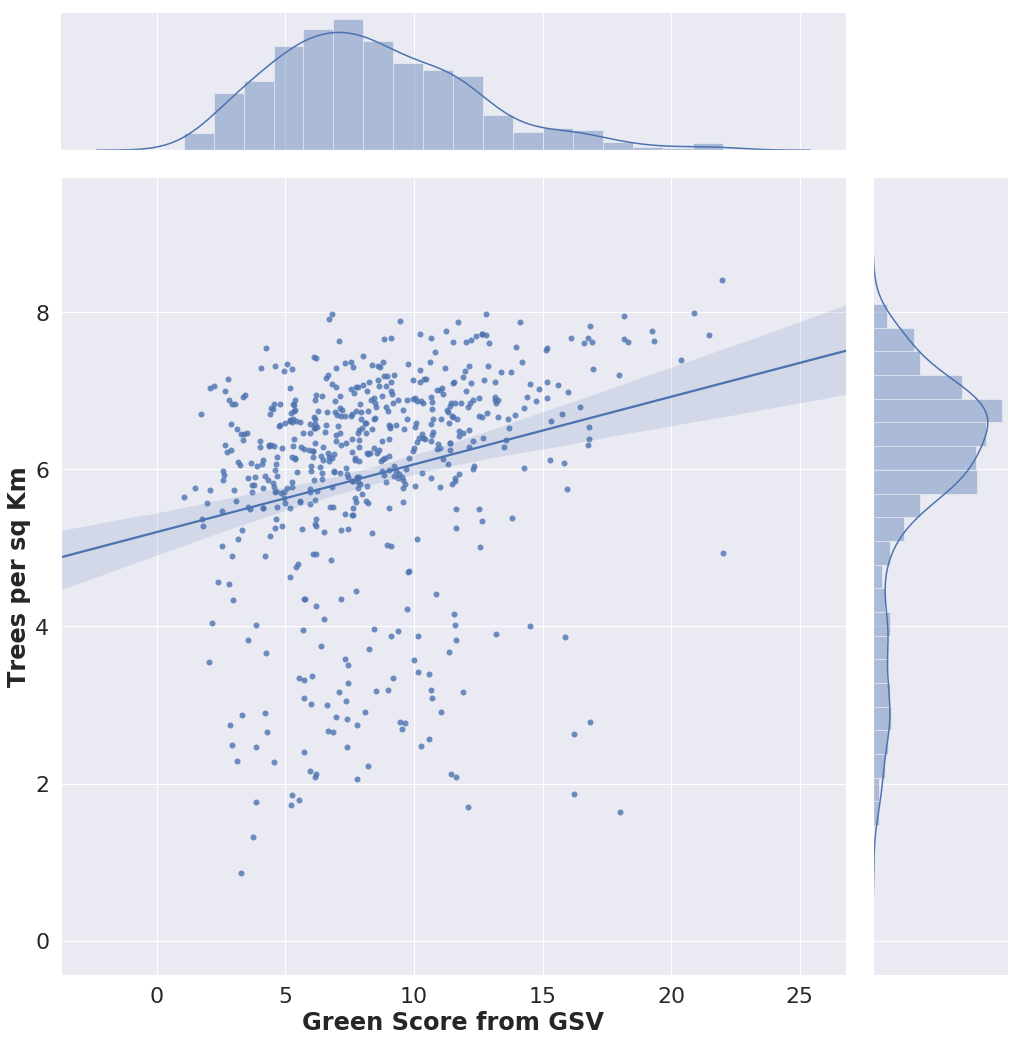

In [146]:
corr = pearsonr(gdf['TreePixelDensity'],gdf['TreeDensity'])
print corr
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.jointplot(x="TreePixelDensity", y="TreeDensity", data=gdf,kind='regression',height=15);
plt.xlabel('Green Score from GSV')
plt.ylabel('Trees per sq Km')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(29, 0.25),fontsize = 20)

In [147]:
GSV_TreeValue = gdf[['borough_name','TreePixelDensity','TreeDensity']].copy()

In [148]:
merged_inner_GSV = pd.merge(left=MergedGLUD,right=GSV_TreeValue, left_on='GSS_CODE', right_on='borough_name')

In [149]:
merged_inner_GSV.head()

,green_score,GSS_CODE,tree_pixels,grass_pixels,urban_pixels,npix,tree_pct,grass_pct,urban_pct,borough_name,TreePixelDensity,TreeDensity
0,8.91957,E05000420,0,0,2387,2387.0,0.000000,0.000000,1.000000,E05000420,10.878568,6.260712
1,41.70052,E05000571,126,391,2999,4085.0,0.030845,0.095716,0.734149,E05000571,7.598941,5.849102
2,18.26981,E05000570,28,180,3339,3717.0,0.007533,0.048426,0.898305,E05000570,8.460213,6.638168
3,27.56138,E05000572,60,540,3284,3964.0,0.015136,0.136226,0.828456,E05000572,5.271470,6.161942
4,41.44914,E05000620,93,214,4834,6408.0,0.014513,0.033396,0.754370,E05000620,5.235384,1.724967


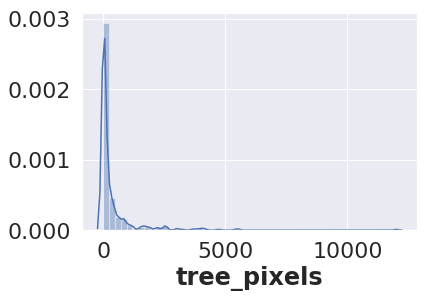

In [150]:
sns.distplot(merged_inner_GSV['tree_pixels'])

(0.7794160984864813, 2.3473216326752744e-89)


Text(60,20,'Pearson r: 0.77***')

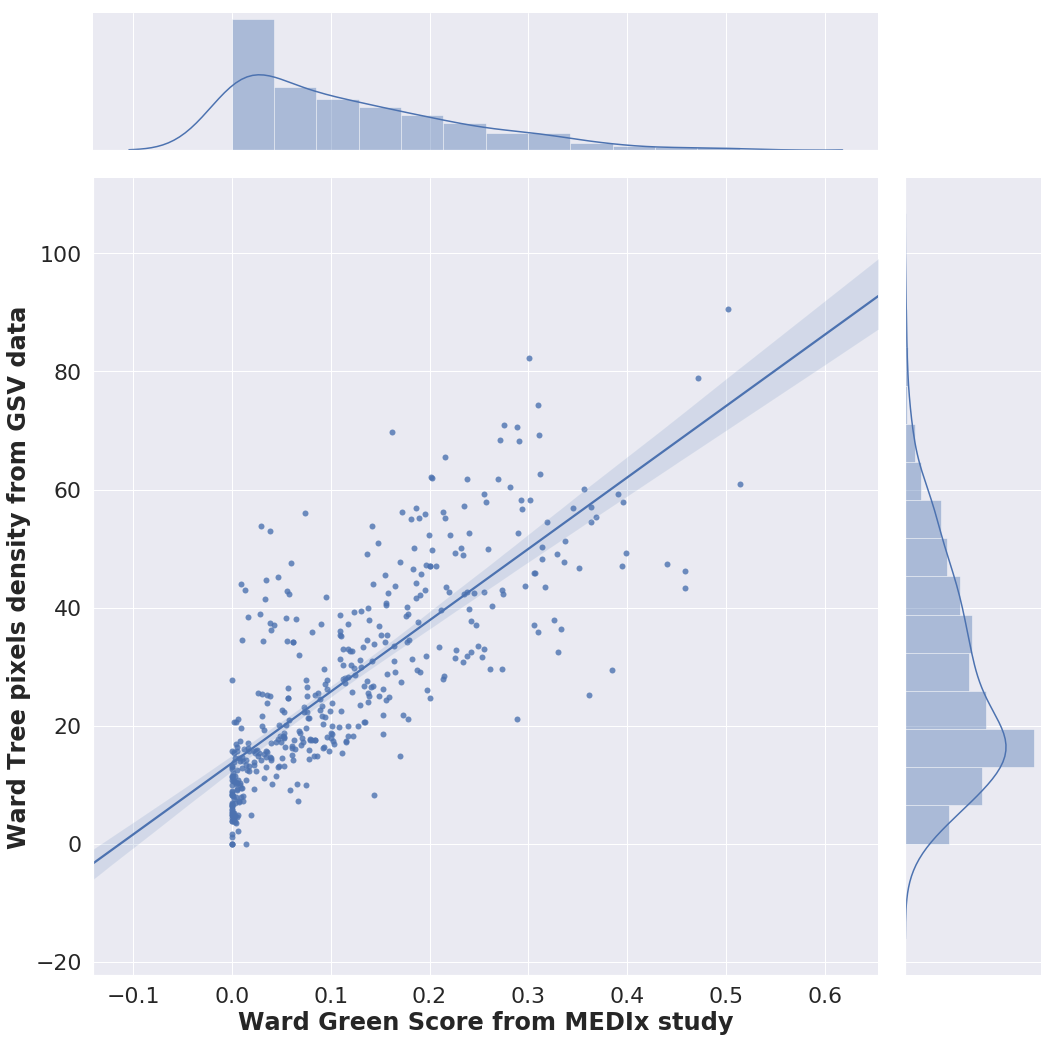

In [171]:
corr = pearsonr(merged_inner_GSV['grass_pct'],merged_inner_GSV['green_score'])
print corr
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.jointplot(x="grass_pct", y="green_score", data=merged_inner_GSV,kind='regression',height=15);
plt.xlabel('Ward Green Score from MEDIx study')
plt.ylabel('Ward Tree pixels density from GSV data')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

(0.6502974697528182, 2.7643736922099653e-53)


Text(60,20,'Pearson r: 0.65***')

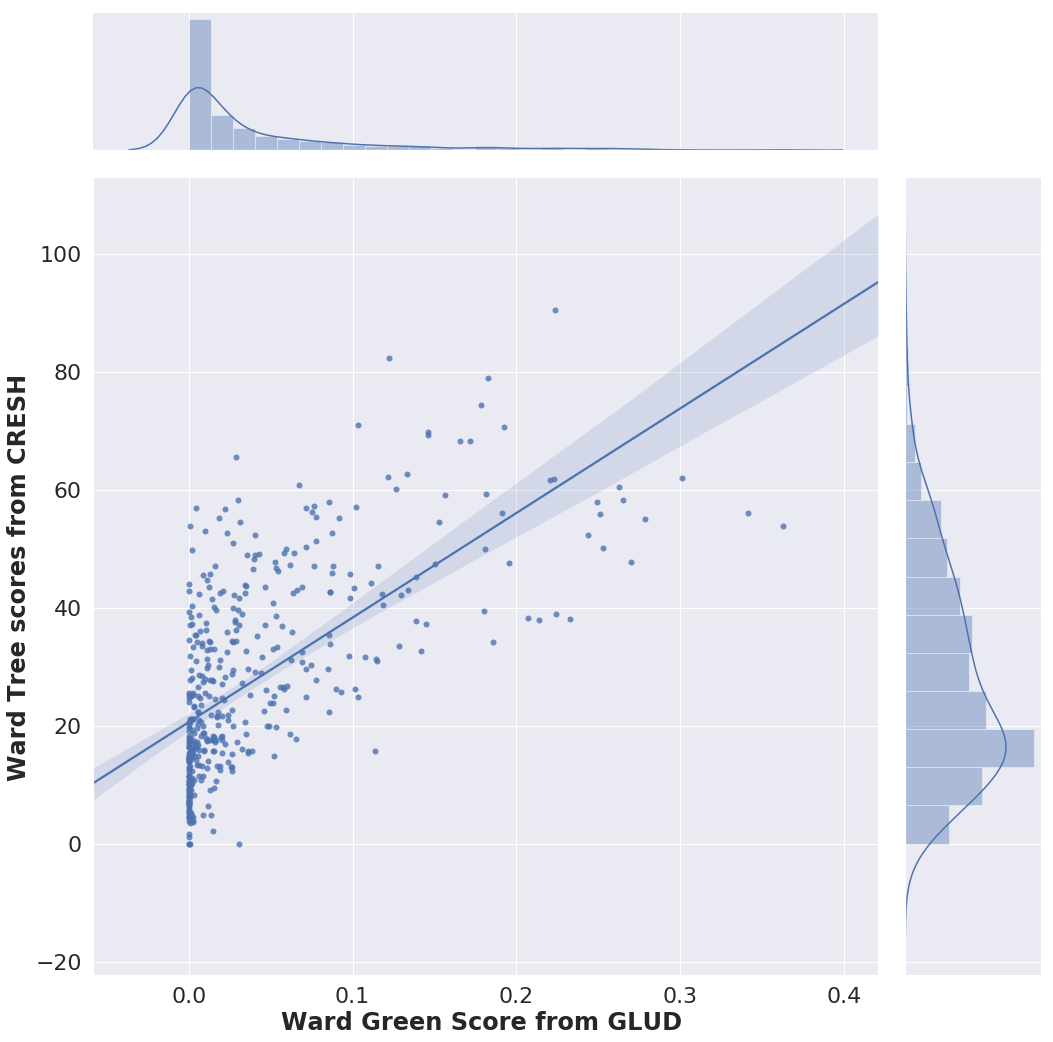

In [130]:
corr = pearsonr(merged_inner_GSV['tree_pct'],merged_inner_GSV['green_score'])
print corr
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.jointplot(x="tree_pct", y="green_score", data=merged_inner_GSV,kind='regression',height=15);
plt.xlabel('Ward Green Score from GLUD ')
plt.ylabel('Ward Tree scores from CRESH')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

(-0.21276756956466014, 8.170973631555897e-06)


Text(60,20,'Pearson r: -0.2***')

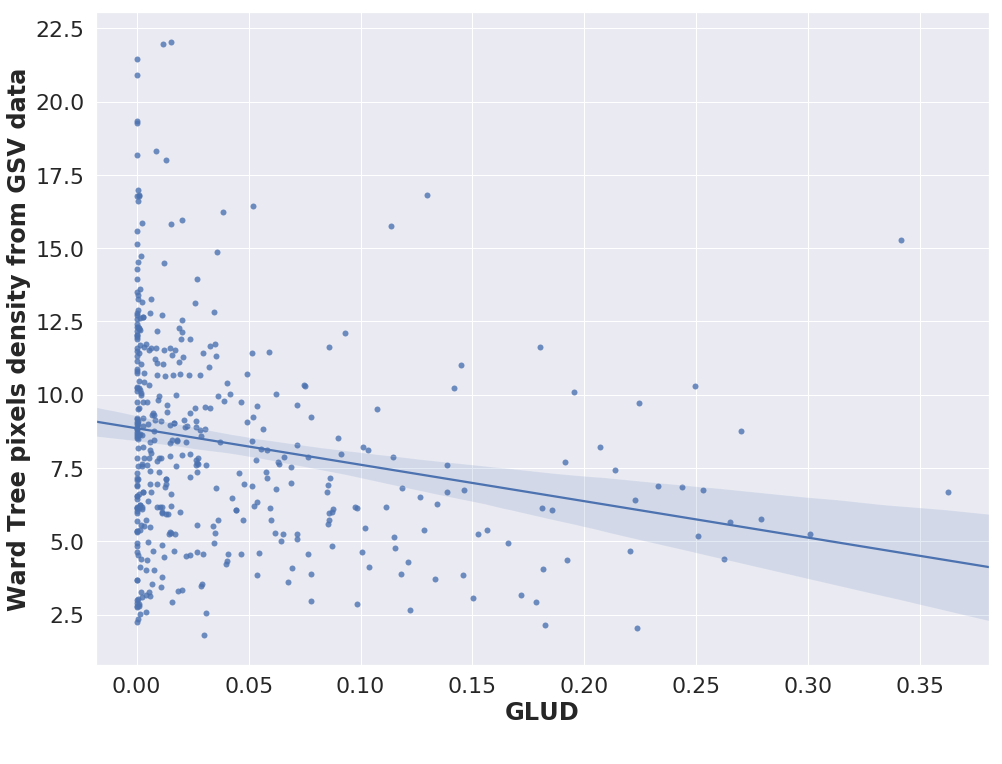

In [131]:
corr = pearsonr(merged_inner_GSV['tree_pct'],merged_inner_GSV['TreePixelDensity'])
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="tree_pct", y="TreePixelDensity", data=merged_inner_GSV);
plt.xlabel('GLUD')
plt.ylabel('Ward Tree pixels density from GSV data')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

In [156]:
import json
diseases  = json.load(open('../Data/health_data/timeSeries_data/prevalence_disease_timeseries.json','rb'))

In [157]:
diseases['201604'].keys()

[u'Ward_Prevalence', u'Ward_Prescriptions']

In [158]:
diseases['201604']['Ward_Prescriptions'].keys()

[u'psoriasis',
 u"Meniere's disease",
 u"crohn's disease",
 u'gastroparesis',
 u'irritable bowel syndrome',
 u'parkinson',
 u'sleep apnea',
 u'interstitial cystitis',
 u'bipolar',
 u'hypothyroidism',
 u'dementia',
 u'rheumatoid',
 u'depression',
 u'diabetes']

In [159]:
def getDiseaase_frame(disease_dict , month ,diseaseName):
    if month in disease_dict:
        dictionary1 = disease_dict[month]['Ward_Prescriptions'][diseaseName]
        dictionary2 = disease_dict[month]['Ward_Prevalence'][diseaseName]
        data = {'GSS_CODE':[] , 'Prescriptions' : [] , 'Prevalence':[]}
        for k in dictionary2:
            data['GSS_CODE'].append(k)
            data['Prescriptions'].append(dictionary1[k])
            data['Prevalence'].append(dictionary2[k])
        dataframe = pd.DataFrame.from_dict(data)
        return dataframe

In [197]:
depression = getDiseaase_frame(diseases, '201105' , 'diabetes')

In [198]:
# merged_inner_GSV

In [199]:
len(depression)

7483

In [200]:
merged_disease = pd.merge(left=merged_inner_GSV,right=depression, left_on='GSS_CODE', right_on='GSS_CODE')

In [201]:
merged_disease['tree_pixels'] = np.log(merged_disease['tree_pixels'] + 1)

In [202]:
merged_disease.head()

,green_score,GSS_CODE,tree_pixels,grass_pixels,urban_pixels,npix,tree_pct,grass_pct,urban_pct,borough_name,TreePixelDensity,TreeDensity,Prescriptions,Prevalence
0,8.91957,E05000420,0.000000,0,2387,2387.0,0.000000,0.000000,1.000000,E05000420,10.878568,6.260712,53452.121298,3.114562
1,41.70052,E05000571,4.844187,391,2999,4085.0,0.030845,0.095716,0.734149,E05000571,7.598941,5.849102,39810.759281,3.305992
2,18.26981,E05000570,3.367296,180,3339,3717.0,0.007533,0.048426,0.898305,E05000570,8.460213,6.638168,34019.292080,3.080899
3,27.56138,E05000572,4.110874,540,3284,3964.0,0.015136,0.136226,0.828456,E05000572,5.271470,6.161942,22704.921944,1.743984
4,41.44914,E05000620,4.543295,214,4834,6408.0,0.014513,0.033396,0.754370,E05000620,5.235384,1.724967,57355.916275,3.224416


(-0.09528192572215556, 0.04779748461129723)


Text(60,20,'Pearson r: -0.0***')

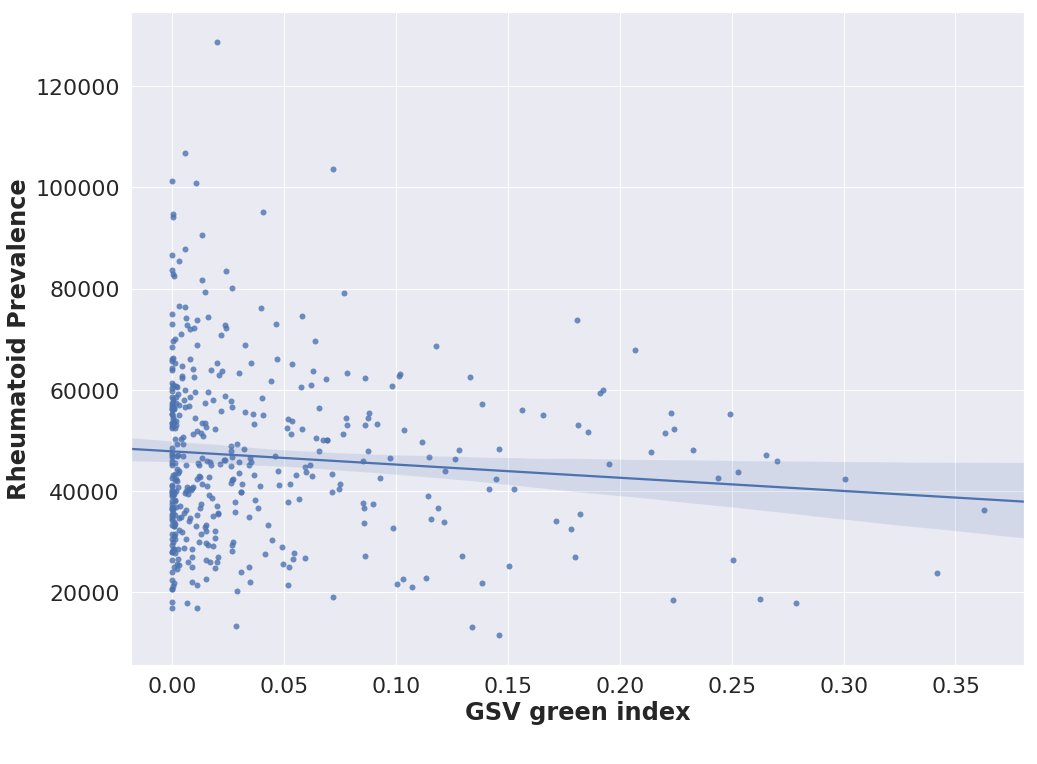

In [206]:
corr = pearsonr(merged_disease['tree_pct'],merged_disease['Prescriptions'])
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="tree_pct", y="Prescriptions", data=merged_disease);
plt.xlabel('GSV green index')
plt.ylabel('Rheumatoid Prevalence')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

(-0.005208545644417422, 0.9140395926854198)


Text(60,20,'Pearson r: -0.0***')

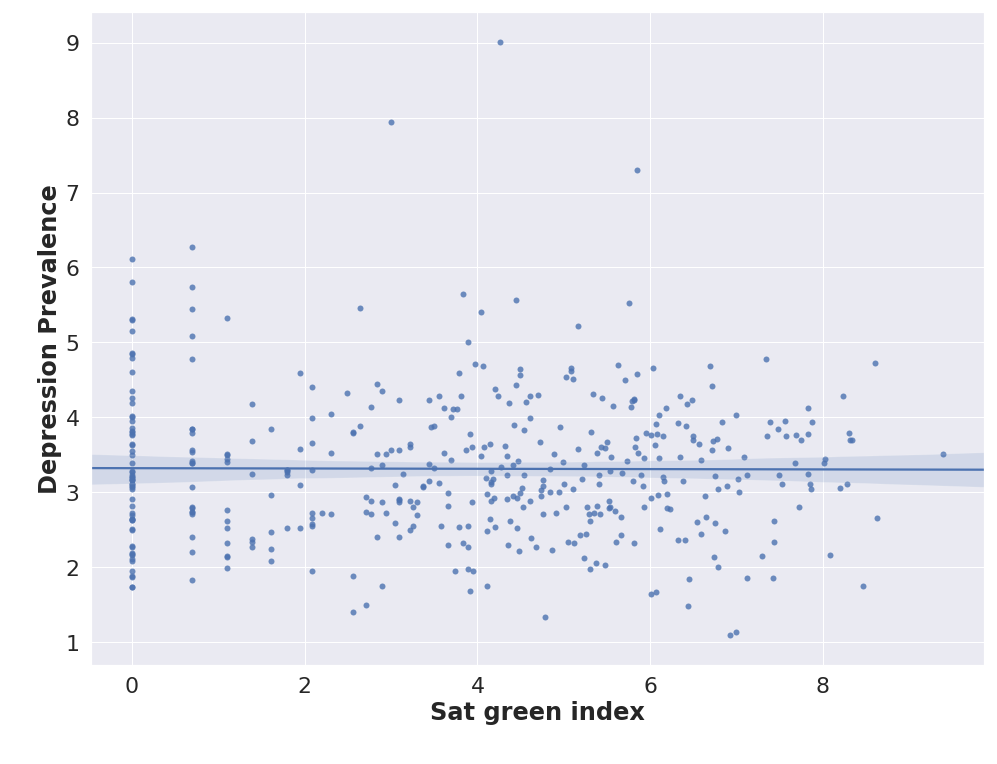

In [204]:
corr = pearsonr(merged_disease['tree_pixels'],merged_disease['Prevalence'])
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="tree_pixels", y="Prevalence", data=merged_disease);
plt.xlabel('Sat green index')
plt.ylabel('Depression Prevalence')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)